In [ ]:
#Design and train the conventional multi-strain system (4.2.2)

In [1]:
import cobra
import numpy as np
import random as rd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Input, concatenate
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras import Model
import math
import pickle
import os
import time
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

In [2]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def metabolites_idlist(mets):
    '''Return a list with the metabolites
    '''
    ms=[]
    for m in mets:
        ms.append(m.id)
    return ms

def build_model_matrix(model):
    '''Build a matrix with the metabolites as rows and the reactions in columns
    with the stechiometric values
    '''
    idList = metabolites_idlist(model.metabolites)
    mat=[]
    for react in model.reactions:
        sp_react = react.reaction.split()
        stechs = [0]*len(idList)
        neg=-1
        num=1
        for ele in sp_react:
            if ele in idList:
                #It's an element
                idx = idList.index(ele)
                stechs[idx] = num*neg 
            elif ele in ['-->', '<=>']:
                neg=1
            elif ele == '+':
                num=1
            elif isfloat(ele):
                num=float(ele)
        mat.append(stechs)
    mat=np.array(mat)
    mat.transpose()
    return mat

In [3]:
def define_medium(model, metabolites):
    '''Define the concentration (fluxes) of the metabolites in the medium
    '''
    with model:
        medium = model.medium
        for metab in metabolites:
            medium[metab] = metabolites[metab]
        model.medium = medium
        model.slim_optimize()
        print(model.summary())
    return medium

def user_medium(model):
    '''Inputs for the user to define the metabolites of the medium
    '''
    with model:
        medium = model.medium
        for exch in model.exchanges:
            if exch.reaction.split()[-1] == '<=>':
                user=input('Flux for metabolite {}: '.format(exch.name))
                if isfloat(user):
                    medium[exch.id] = float(user)
        model.medium = medium
        nmodel=model.copy()
    return nmodel

def check_fluxes(model):
    '''Print the non zero in and out fluxes os a metabolism optimized by FBA
    '''
    model.optimize()
    influxes, outfluxes = [],[]
    for exch in model.exchanges:
        if exch.flux > 0:
            outfluxes.append(exch)
        elif exch.flux < 0:
            influxes.append(exch)

    print('In fluxes')
    for exch in influxes:
        print(exch.id,':\t', exch.flux)

    print('\nOut fluxes')
    for exch in outfluxes:
        print(exch.id,':\t', exch.flux)

def get_fluxesIds(m):
    '''Return the metabolites that are exchanged in and out of the cell
    '''
    fluxes = []
    for exch in m.exchanges:
        fluxes.append(exch.id)
    fluxes.append('Biomass')
    return fluxes

def get_fluxes(m):
    '''Return the metabolites that are exchanged in and out of the cell
    '''
    fluxes = {}
    for exch in m.exchanges:
        fluxes[exch.id] = exch.flux
    return fluxes

def compare_fluxes_metabs(m1, m2):
    '''Print the different exchange metabolites between 2 metabolism models
    '''
    set1 = set(get_fluxes(m1))
    set2 = set(get_fluxes(m2))
    return set1.symmetric_difference(set2)

def get_influxesIds(m):
    '''Returns a set with the metabolites that can be taken by the cell
    '''
    influxes = []
    for exch in m.exchanges:
        if exch.reaction.split()[-1] == '<=>':
            influxes.append(exch.id)
    if 'EX_h2o_e' in influxes:
        influxes.remove('EX_h2o_e')
    return influxes

def compare_influxes(m1,m2):
    set1 = set(get_influxes(m1))
    set2 = set(get_influxes(m2))
    return set1.symmetric_difference(set2)

def getReactionsIds(m):
    '''Return a list with the reactions in a model'''
    reacts=[]
    for r in m.reactions:
        reacts.append(r.id)
    return reacts

def biomassIndex(fluxes_metabs):
    '''Returns the index of the biomass'''
    for i in range(len(fluxes_metabs)):
        if 'BIOMASS' in fluxes_metabs[i].upper():
            return i

In [4]:
def random_medium(model, mini=0.001, maxi=20):
    '''Return a dictionary with random values for the metabolites ina  medium
    '''
    medium={}
    inputIds = get_influxesIds(model)
    for metab in inputIds:
        medium[metab] = rd.uniform(mini, maxi)
    return medium

def FBA_output_fluxes(model, medium):
    '''Returns the exchanged fluxes and the biomass with FBA
    '''
    with model:
        model.medium = medium
        biomass=model.slim_optimize()
        if math.isnan(biomass):
            return None
        #print(model.summary())
        fluxes = get_fluxes(model)
        fluxes['biomass'] = biomass
    return fluxes

def dics_to_dicOfLists(dics):
    ndic = {}
    for dic in dics:
        for key in dic:
            if key in ndic:
                ndic[key].append(dic[key])
            else:
                ndic[key] = [dic[key]]
    return ndic

def batch_of_FBAs(model, num=100, maxi=1000):
    '''Returns two lists with the dictionaries of mediums and fluxes
    '''
    all_mediums = []
    all_fluxes = []
    i=0
    t0=time.time()
    while i<num:
        cur_medium = random_medium(model, maxi=maxi)
        cur_fluxes = FBA_output_fluxes(model, cur_medium)
        if not cur_fluxes == None:
            if i%(num/10)==0:
                print('Created {}/{}'.format(i,num))
            all_mediums.append(cur_medium)
            all_fluxes.append(cur_fluxes)
            i+=1
    print('Total time: ',time.time()-t0)
    all_mediums = dics_to_dicOfLists(all_mediums)
    all_fluxes = dics_to_dicOfLists(all_fluxes)
    print('Created {}/{}'.format(num,num))
    return all_mediums, all_fluxes

def build_sets(mediums, fluxes):
    '''Returns two lists of inputs and outputs as lists of lists'''
    inputs, outputs = [], []
    for metab in mediums:
        inputs.append(mediums[metab])
    for metab in fluxes:
        outputs.append(fluxes[metab])
    inputs, outputs = np.array(inputs).T, np.array(outputs).T
    return inputs, outputs

def pickle_save(data,filebase, append=False):
    '''Saves the input and output with pickle. '''
    inputs, outputs = data
    infn, outfn = filebase + '_inputs.pickle', filebase + '_outputs.pickle'
    if infn in os.listdir() or outfn in os.listdir():
        if append:
            preinp, preout = pickle_load(infn, outfn)
            inputs = np.append(preinp,inputs,axis=0)
            outputs = np.append(preout,outputs,axis=0)
            with open(infn, 'wb') as handle:
                pickle.dump(inputs, handle)
            with open(outfn, 'wb') as handle:
                pickle.dump(outputs, handle)
            return
        else:
            filebase += '_2'
            infn, outfn = filebase + '_inputs.pickle', filebase + '_outputs.pickle'
    with open(infn, 'wb') as handle:
        pickle.dump(inputs, handle)
    with open(outfn, 'wb') as handle:
        pickle.dump(outputs, handle)

def pickle_load(infn, outfn):
    with open(infn,'rb') as finputs:
        inputs = pickle.load(finputs)
    with open(outfn, 'rb') as foutputs:
        outputs = pickle.load(foutputs)
    return inputs, outputs

def mean_square_error(a,b):
    '''Mean square error between two list numpy arrays'''
    return np.square(a-b).mean()

def mean_absolute_error(a,b):
    '''Mean absolute error between two list numpy arrays'''
    return np.abs(a-b).mean()

def RRMSE(preds, reals):
    '''Calculates the Relative Root Mean Squared Error for each variable (column)
    Return a list with each variable RRMSE'''
    rs=[]
    for j in range(preds.shape[1]):
        meanj = np.mean(reals[:,j])
        up, down = 0,0
        for i in range(preds.shape[0]):
            up += (reals[i,j]-preds[i,j])**2
            down += (reals[i,j]-meanj)**2
        rs.append(math.sqrt(up/down))
    return rs

def aRRMSE(preds, reals):
    '''Calculates the average Relative Root Mean Squared Error for each variable (column)
    Return the aRRMSE'''
    return np.sum(RRMSE(preds, reals)) / preds.shape[1]
        
def pearson(a,b):
    cors=[]
    for i in range(a.shape[1]):
        c = pearsonr(a[:,i],b[:,i])[0]
        cors.append(c)
    return cors

def spearman(a,b):
    cors=[]
    for i in range(a.shape[1]):
        c = spearmanr(a[:,i],b[:,i])[0]
        cors.append(c)
    return cors

def divide_set(s, train_prop, val_prop):
    '''Return the set divided in training, validationa and test sets'''
    val_prop = train_prop + val_prop
    x_train, x_val, x_test = s[:int(train_prop*s.shape[0])], s[int(train_prop*s.shape[0]):int(val_prop*s.shape[0])], s[int(val_prop*s.shape[0]):]
    return x_train, x_val, x_test

def shuffle_dataset(datas):
    '''Randomly shuffles the databaset inputs and outputs with the same order (their rows are shuffled)'''
    s = np.arange(datas[0].shape[0])
    np.random.shuffle(s)
    for i in range(len(datas)):
        datas[i] = datas[i][s,:]
    return datas

In [5]:
def nonzeroidx_output(output, limit = 0.01):
    '''Find the metabolites that change for all the dataset. A metabolite is considered not to change if its values
    are 0 for more than (1-limit) proportion'''
    #Removing output metabolites which abs mean(change) is less than 0.001
    nonzero = limit*output.shape[0]
    nonzeros_idx=[]
    for j in range(output.shape[1]):
        cur_nonzeros = len(np.where(abs(output[:,j])>0.001)[0])
        if cur_nonzeros > nonzero:
            nonzeros_idx.append(j)
    return nonzeros_idx

def nonCommonReactions(a):
    '''Return the indexs of the columns where not all values are 1'''
    idxs = []
    for j in range(a.shape[1]):
        if sum(a[:,j]) != a.shape[0]:
            idxs.append(j)
    return idxs

#Normalize the outputs
def norm_outputs(outputs, incr=0):
    '''Normalize the outputs as (X-min)/(max-min)
    The range can be increased a % over the maximum and minimum so the predictions can excede the 
    dataset values'''
    mins = np.min(outputs,axis=0) - np.abs(np.min(outputs, axis=0)*incr)
    maxs = np.max(outputs,axis=0) + np.abs(np.max(outputs, axis=0)*incr)
    return (outputs-mins) / (maxs-mins), maxs, mins

def norm2real(predictions,maxs,mins):
    '''Return the denormalized values of the output'''
    return predictions * (maxs-mins) + mins

def real2norm(predictions, maxs, mins):
    '''Return the normalized values of the output (with predefined maxs and mins)'''
    return (predictions-mins) / (maxs-mins)
    
def plot_prediction_comparison(predictions, real, metab):
    '''Plot an histogram with the real and several predicted values overlapped'''
    maxi=100
    if len(real) > maxi:
        for i in range(len(predictions)):                       
            predictions[i]=predictions[i][:maxi]
        real=real[:maxi]
    
    bins = list(range(len(real)))
    if len(predictions) == 1:                           
        x, y = zip(*sorted(zip(real, predictions[0])))
    else:
        x, y, z = zip(*sorted(zip(real, predictions[0], predictions[1])))
        plt.scatter(bins, z, alpha=0.5, label='Prediction 2')

    plt.scatter(bins, x, alpha=0.5, label='Real')
    plt.scatter(bins, y, alpha=0.5, label='Prediction 1')
    plt.legend(loc='upper left')
    plt.title('Metabolite: {}'.format(metab))
    plt.show()

In [6]:
def dataset2dic(inputs, outputs, FBAmodel, numberFBAs=-1):
    '''Returns the input, output as dictionaries with the ids of the metabolites as keys'''
    inps, outs = {}, {}
    medium_metabs = get_influxesIds(FBAmodel)
    fluxes_metabs = get_fluxesIds(FBAmodel)
    if numberFBAs == -1:
        numberFBAs = inputs.shape[0]
    for i in range(len(medium_metabs)):
        inps[medium_metabs[i]] = list(inputs[:numberFBAs,i])
    
    for i in range(len(fluxes_metabs)):
        outs[fluxes_metabs[i]] = list(outputs[:numberFBAs,i])
    return inps, outs

def addMetab2dic(metab, dic, ninds):
    '''Add a metabolite to the dic that was not present before, filling with zeros that metabolite in the previous indivs'''
    dic[metab] = [0] * ninds
    return dic

def addDicIndivs(cur_dic, total_dic, addNew=True):
    '''Add the data in the cur_dic into the total_dic
    Metabs in the toal_dic that are not found in cur_dic are filled with 0s for this cur_dic individuals
    Metabs in the cur_dic that are not found in the total_dic are added filling with 0s for the previous individuals (addMetab2dic)'''
    ninds = len(cur_dic[list(cur_dic.keys())[0]])
    if total_dic == {}:
        prev_ninds = 0
    else:
        prev_ninds = len(total_dic[list(total_dic.keys())[0]])
    for metab in total_dic:
        if metab in cur_dic:
            total_dic[metab] += cur_dic[metab]
        else:
            total_dic[metab] += [0]*ninds
    if addNew:
        for metab in cur_dic:
            if not metab in total_dic:
                total_dic = addMetab2dic(metab,total_dic, prev_ninds)
                total_dic[metab] += cur_dic[metab]
    return total_dic

def dic2array(dic):
    '''Return an array that is complementary to the dictionary and the keys of the dictionary'''
    data = []
    for metab in dic:
        data.append(np.array(dic[metab]))
    data = np.array(data).T
    return data, list(dic.keys())

def reorder_data(tmetabs, nmetabs, ndata):
    '''Reorder the data (input or output) in the order of tmetab, when the data columns are in nmetabs order'''
    idxs=[]
    for ia in tmetabs:
        idxs.append(nmetabs.index(ia))
    return ndata[:,idxs], np.array(nmetabs)[idxs]

def addStrainColumn(inputs, strain):
    '''Add a column to the inputs which represents the strain number'''
    return np.vstack((inputs.T, [strain]*inputs.shape[0])).T

def emptyDic(dic):
    '''Return an empty dic maintaining the keys'''
    ndic={}
    for k in dic:
        ndic[k]=[]
    return ndic

def createMetabDic(FBAmodel, nFBAs):
    dic={}
    for r in FBAmodel.reactions:
        dic[r.id] = [1]*nFBAs
    return 

def getNonCommonReactions(models):
    '''Returns a list with the common reactions'''
    reacts, common = set(), []
    for m in models:
        curReacts = getReactionsIds(m)
        reacts=reacts.union(curReacts)
        if common == []:
            common = set(curReacts)
        else:
            common = common.intersection(set(curReacts))
    nonCommon = reacts.difference(common)
    return list(nonCommon)

def oneHotVector(inputs, models, ind=None):
    '''Returns a one-hot vectors array for the inputs. Divided for the different models'''
    inputsHot = []
    for i in range(len(models)):
        for j in range(int(inputs.shape[0]/len(models))):
            inputsHot.append([0]*len(models))
            if ind == None:
                inputsHot[-1][i]=1
            else:
                inputsHot[-1][ind]=1
    return np.array(inputsHot)


def createMetabolismInput(models, nFBAs, encode):
    '''Creates the metabolisms input where the presence abscense of non common reactions are shown'''
    nonCommon = getNonCommonReactions(models)
    rows, enrows = [], []
    for m in models:
        cur_react = getReactionsIds(m)
        row=[]
        for r in nonCommon:
            if r in cur_react:
                row.append(1)
            else:
                row.append(0)
        enrow=encodeSbin(row, batch=encode, code='binary')
        rows.append(row)
        enrows.append(enrow)
    return np.repeat(rows, nFBAs, axis=0), np.repeat(enrows, nFBAs, axis=0), nonCommon

def obtainMetabolismInput(FBAmodel, nFBAs, nonCommon):
    '''Given the reactions chosen as the metabolic input (nonCommon), it creates an inputs metabolism array
    from other model, setting to 0 those reactions absent'''
    row = []
    mreacts = getReactionsIds(FBAmodel)
    for r in nonCommon:
        if r in mreacts:
            row.append(1)
        else:
            row.append(0)
    return np.repeat([row], nFBAs, axis=0)

def list2str(vect):
    return ''.join((str(i) for i in vect))

def invert_bin(s):
    '''Inverts a binary string
    '''
    ivs = ''
    for c in s:
        if c=='0':
            ivs+='1'
        elif c=='1':
            ivs+='0'
    return ivs

def c2(s):
    '''Converts a binary string in complement to 2 into its decimal value. Range in positive.
    '''
    sign, val = 1, 0
    if s[0]=='1':
        sign, val = -1, -1
        s = invert_bin(s)
    return sign * int(s,2) + val + 2**(len(s)-1)

def chain_value(s, code='binary'):
    '''Return the decimal value o a binary string depending on the code
    '''
    if code == 'binary':
        val=int(s,2)
    elif code == 'c2':
        val = c2(s)
    return val

def encodeSbin(vbin, batch, code='binary'):
    '''Encode a binary vector transforming batches into its decimal values
    '''
    v, s = [], list2str(vbin)
    for i in range(0, len(s), batch):
        val = chain_value(s[i:i+batch], code)
        v.append(val)
    return v

In [7]:
def neural_net_adv(x_train_metab, x_train_medium, y_train, x_val_metab, x_val_medium, y_val, nepochs=20, vb=2):
    '''Creates and trains a forked network'''
    metabolism = Input(shape=(x_train_metab.shape[1],))
    medium = Input(shape=(x_train_medium.shape[1],))

    x = Dense(128, activation='relu')(metabolism)
    x = Dense(64, activation='relu')(x)
         
    x=concatenate([x,medium])
    x=Dense(64, activation='relu')(x)
    x=Dense(64, activation='relu')(x)
    x=Dense(64, activation='relu')(x)
        
    output=Dense(y_train.shape[1], activation='relu')(x)

    model=Model(inputs=[metabolism,medium],outputs=[output])
    
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    history = model.fit([x_train_metab, x_train_medium] , y_train, 
                        epochs=nepochs, verbose=vb , 
                        validation_data=([x_val_metab, x_val_medium], y_val))
    
    return history, model

def neural_net_sequential(x_train, y_train, x_val=0, y_val=0, nepochs=20, vb=2):
    '''Creates and trains the conventional network'''
    ninp, nout = x_train.shape[1], y_train.shape[1]
    model = tf.keras.Sequential()
    model.add(Dense(64, input_shape=(ninp,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nout))
    model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae'])
    if x_val == 0 and y_val == 0:
        history = model.fit(x_train, y_train, epochs=nepochs, verbose=vb)
    else:
        history = model.fit(x_train, y_train, epochs=nepochs, verbose=vb , validation_data=(x_val, y_val))
    return history, model

def plot_output(history, model):
    # PLOT LOSS AND ACCURACY
    %matplotlib inline
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data sets for each training epoch
    #-----------------------------------------------------------
    acc=history.history['mean_absolute_error']
    loss=history.history['loss']
    epochs=range(len(acc)) # Get number of epochs
    
    val_acc=history.history['val_mean_absolute_error']
    val_loss=history.history['val_loss']

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', label="Training Loss")
    plt.plot(epochs, val_loss, 'b', label="Validation Loss")
    plt.legend(loc='upper right')

    plt.title('Training and validation loss')
    plt.show()
    
def error_rates(pred, test):
    '''Returns the error rates as abs(pred-test) / absavg(pred,test)'''
    diff = np.abs(pred-test)
    absavg = np.abs((pred+test)/2)
    absavg[np.where(absavg==0)]=0.00000001
    return np.sum(diff/absavg, axis=0)

def mean_absolute_error(a,b):
    '''Mean squared error between two list numpy arrays'''
    return np.abs(a-b).mean()

def copyKerasModel(model):
    '''Return a deep copy of a keras model'''
    model_copy=clone_model(model)
    model_copy.compile(optimizer='Adam', loss='mean_squared_error', metrics = ['mae'])
    model_copy.set_weights(model.get_weights())
    return model_copy

def getModelBases_fromDir(dire):
    '''Get all the json model names stored in the directory'''
    modelBases = []
    for f in os.listdir(dire):
        if '.json' in f:
            modelBases.append(f.split('.')[0])
    return modelBases

In [8]:
#Big functions
def loadFBAdics(modelBase, modelFolder = '', append=False, number_of_FBAs = 5000):
    '''Returns the inputs, outputs as dictionaries'''
    database = 'FBAs_{}_random'.format(modelBase)
    FBAmodel = cobra.io.load_json_model(modelFolder+modelBase+'.json')
    
    premade_FBA = [database+'_inputs.pickle', database+'_outputs.pickle']
    medium_metabs = get_influxesIds(FBAmodel)
    fluxes_metabs_raw = get_fluxesIds(FBAmodel)
    
    if not append and premade_FBA[0] in os.listdir() and premade_FBA[1] in os.listdir():
        inputs, outputs = pickle_load(premade_FBA[0], premade_FBA[1])
    else:
        all_mediums, all_fluxes = batch_of_FBAs(FBAmodel, number_of_FBAs)
        inputs, outputs = build_sets(all_mediums, all_fluxes)
        pickle_save([inputs, outputs], database, append)
        if append:
            inputs, outputs = pickle_load(premade_FBA[0], premade_FBA[1])
    
    return dataset2dic(inputs, outputs, FBAmodel)

def runFBAs(FBAmodel, database, nFBAs=5000, append=True):
    '''Run FBA simulations and store the results'''
    print('Running model: ', FBAmodel.id)
    all_mediums, all_fluxes = batch_of_FBAs(FBAmodel, nFBAs)
    inputs, outputs = build_sets(all_mediums, all_fluxes)
    pickle_save([inputs, outputs], database, append)

def runMultipleFBAs(models, databases, nFBAs=5000, append=True):
    '''Run multiple models FBAs and save them'''
    for i in range(len(models)):
        FBAmodel, database = models[i], databases[i]
        runFBAs(FBAmodel, nFBAs, database, append)

def adaptInputOutputofFBA(ori_inputs, ori_outputs, FBAmodel, net_inputs_dic, net_outputs_dic):
    '''Adapts a FBAmodel dataset to have the same inputs and outpus of the neural network trained model
    Modify the dataset for having the same input-output metabolites as the net expectes (0 if they don't exist)
    Returns: Inputs dictionary, outputs dictionary'''
    #Remove mold individuals from the dataset, adapting the dataset to the model inputs, outputs
    inputs_dic, outputs_dic = emptyDic(net_inputs_dic), emptyDic(net_outputs_dic)
    
    cur_inp_dic, cur_out_dic = dataset2dic(ori_inputs, ori_outputs, FBAmodel, ori_inputs.shape[0])
    inputs_dic, outputs_dic = addDicIndivs(cur_inp_dic, inputs_dic, False), addDicIndivs(cur_out_dic, outputs_dic, False)
    return inputs_dic, outputs_dic

In [15]:
#Load the models
dataFolder = 'modelsMixed/'
modelBases = ['iEC042']#,'iAPECO1','iJO1366', 'iWFL']#, 'iYS1720']

if 'all' in modelBases:
    modelBases = getModelBases_fromDir(dataFolder)


modelFns, dataBases, models = [], [], []
for ib in modelBases:
    modelFns.append(ib+'.json')
    dataBases.append('FBAs_{}_random'.format(ib))
    models.append(cobra.io.load_json_model(dataFolder+ib+'.json'))

print(len(models),' models loaded')
print(models)
#modMatrix = build_model_matrix(model)

#nFBAs = 10000
#torun = True
#if torun:
 #   runMultipleFBAs(models, dataBases, nFBAs)

1  models loaded
[<Model iEC042_1314 at 0x17a056d7eb8>]


In [16]:
#Load the dataset of the cobra models
number_of_FBAs = 10000
append=True
maxi_metab = 1000
#Load one model or all
all_models=True
idx=4
addStrain=False

if not all_models:
    database = dataBases[idx]
    print('Loading model: ',database)
    FBAmodel = models[idx]
    premade_FBA = [database+'_inputs.pickle', database+'_outputs.pickle']
    medium_metabs = get_influxesIds(FBAmodel)
    fluxes_metabs_raw = get_fluxesIds(FBAmodel)
    
    if append or not premade_FBA[0] in os.listdir() or not premade_FBA[1] in os.listdir():
        runFBAs(FBAmodel, database, number_of_FBAs, append)
    inputs, outputs = pickle_load(premade_FBA[0], premade_FBA[1])
    ori_outputs=outputs.copy()
else:
    #Loading all models in the same dataset
    fmodels=[]
    net_inputs_dic, inputsM_dic, net_outputs_dic = {}, {}, {}
    for imodel in range(len(models)):
        database = dataBases[imodel]
        FBAmodel = models[imodel]
        print('Adding model {}'.format(database))
        premade_FBA = [database+'_inputs.pickle', database+'_outputs.pickle']
        
        if not append and premade_FBA[0] in os.listdir() and premade_FBA[1] in os.listdir():
            cur_inp, cur_out = pickle_load(premade_FBA[0], premade_FBA[1])
            
            if cur_inp.shape[0] < number_of_FBAs:
                runFBAs(FBAmodel, database, number_of_FBAs-cur_inp.shape[0], append=True)
        else:
            runFBAs(FBAmodel, database, number_of_FBAs, append)
            
        cur_inp, cur_out = pickle_load(premade_FBA[0], premade_FBA[1])
        #Converts the dataset into dictionaries and selects just the number of specified FBAs
        cur_inp_dic, cur_out_dic = dataset2dic(cur_inp, cur_out, FBAmodel, number_of_FBAs) 
        if np.mean(cur_out_dic['Biomass']) < 0.1:
            print('Model {} did not grow'.format(dataBases[imodel]))
        else:
            net_inputs_dic, net_outputs_dic = addDicIndivs(cur_inp_dic, net_inputs_dic), addDicIndivs(cur_out_dic, net_outputs_dic)
            fmodels.append(models[imodel])
    models=fmodels
    print('All models loaded')


Adding model FBAs_iEC042_random
Running model:  iEC042_1314
Created 0/10000
Created 1000/10000
Created 2000/10000
Created 3000/10000
Created 4000/10000
Created 5000/10000
Created 6000/10000
Created 7000/10000
Created 8000/10000
Created 9000/10000
Total time:  1160.3759887218475
Created 10000/10000
All models loaded


In [11]:
#Transfrom the dataset into arrays 
inputs, medium_metabs = dic2array(net_inputs_dic)
outputs, fluxes_metabs_raw = dic2array(net_outputs_dic)

#inputsM, encoded_inputsM, inputReactions = createMetabolismInput(models, number_of_FBAs, encode=4)
#print('Input metabolisms shape: ',inputsM.shape)
print('Input shape: ',inputs.shape)
print('Output shape: ',outputs.shape)

In [13]:
#Filter the output metabolites, only predicted those with considerable change
nonzeros_idx = nonzeroidx_output(outputs, limit = 0.05)
outputs = outputs[:,nonzeros_idx]
fluxes_metabs = np.array(fluxes_metabs_raw)[nonzeros_idx]

print('Input metabolisms shape: ',inputsM.shape)
print('Input shape: ',inputs.shape)
print('Output shape: ',outputs.shape)

Input metabolisms shape:  (10000, 373)
Input shape:  (10000, 24)
Output shape:  (10000, 25)


In [14]:
#Normalize inputs and outputs
inputs/=1000
outputs_norm, out_maxs, out_mins = norm_outputs(outputs)

print('Input shape: ',inputs.shape)
print('Output shape: ',outputs_norm.shape)

Input shape:  (10000, 24)
Output shape:  (10000, 25)


In [15]:
#Adding the one hot vector input
inputsHot = oneHotVector(inputs, models)
inputsHot = np.concatenate((inputsHot, inputs),axis=1)
print('Input hot shape: ',inputsHot.shape)

#Merge input
#inputsAll = np.concatenate((inputs,inputsM),axis=1)
#inputsAll = np.concatenate((inputs,encoded_inputsM),axis=1)
#print('All inputs shape: ',inputsAll.shape)

Input hot shape:  (10000, 28)
All inputs shape:  (10000, 397)


In [16]:
#Shuffling rows
inputs, inputsHot, outputs, outputs_norm = shuffle_dataset([inputs, inputsHot, outputs, outputs_norm])

In [42]:
#Red secuencial only metabs
net_fn = 'Sequential_metabs_mixed_net.h5'
redo = True
if net_fn in os.listdir() and not redo:
    model_met = load_model(net_fn)
else:
    history_met, model_met = neural_net_sequential(inputs,outputs_norm,nepochs=10,vb=1)
    #plot_output(history_met, model_met)
    model_met.save(net_fn)

Epoch 1/10
10000/10000 [==============================] - 1s 112us/sample - loss: 0.0583 - mean_absolute_error: 0.1756
Epoch 2/10
10000/10000 [==============================] - 1s 66us/sample - loss: 0.0224 - mean_absolute_error: 0.1065
Epoch 3/10
10000/10000 [==============================] - 1s 112us/sample - loss: 0.0145 - mean_absolute_error: 0.0830
Epoch 4/10
10000/10000 [==============================] - 1s 108us/sample - loss: 0.0116 - mean_absolute_error: 0.0707
Epoch 5/10
10000/10000 [==============================] - 1s 82us/sample - loss: 0.0100 - mean_absolute_error: 0.0625
Epoch 6/10
10000/10000 [==============================] - 1s 69us/sample - loss: 0.0089 - mean_absolute_error: 0.0563
Epoch 7/10
10000/10000 [==============================] - 1s 67us/sample - loss: 0.0082 - mean_absolute_error: 0.0520
Epoch 8/10
10000/10000 [==============================] - 1s 70us/sample - loss: 0.0079 - mean_absolute_error: 0.0496
Epoch 9/10
10000/10000 [=============================

In [32]:
print('\n# Evaluate on test data. Results from sequential only metabs')
results_met = model_met.evaluate(inputs, outputs_norm)
predictions_met = model_met.predict(inputs)
#a_seq = RRMSE(predictions_seq, y_test)
#print('aRRMSE sequential: ', a_seq)


# Evaluate on test data. Results from sequential only metabs
10000/10000 [==============================] - 0s 50us/sample - loss: 0.0073 - mean_absolute_error: 0.0456


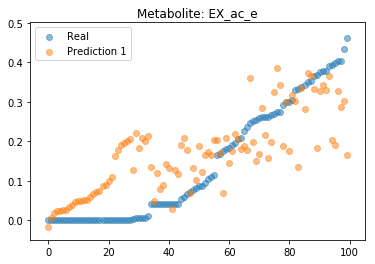

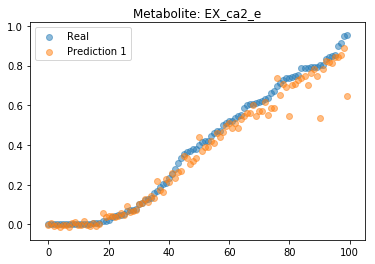

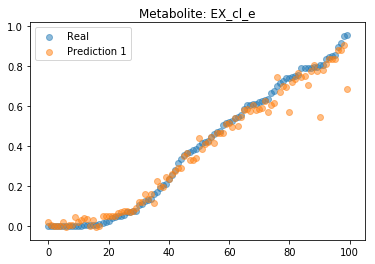

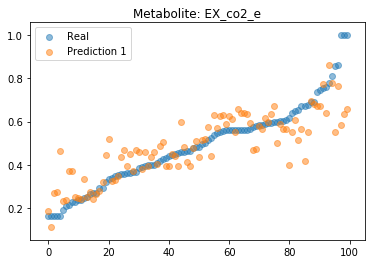

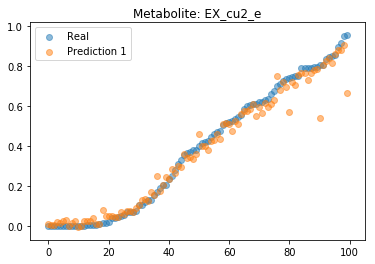

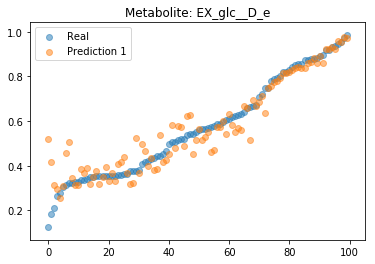

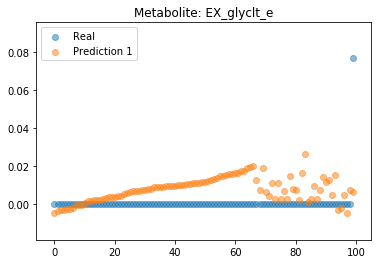

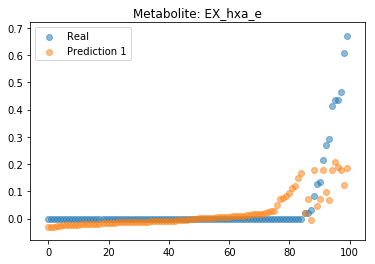

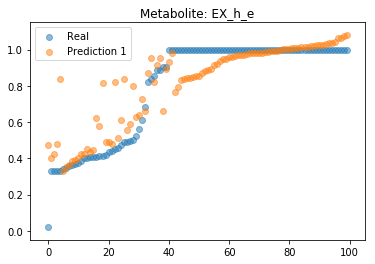

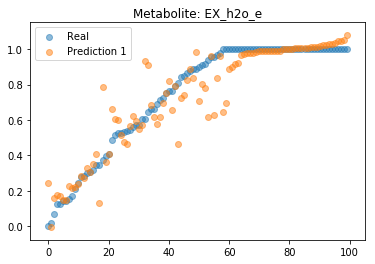

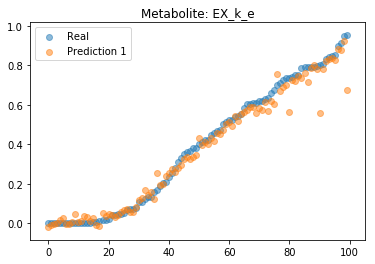

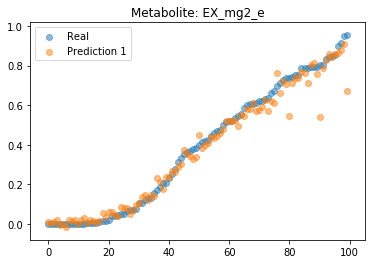

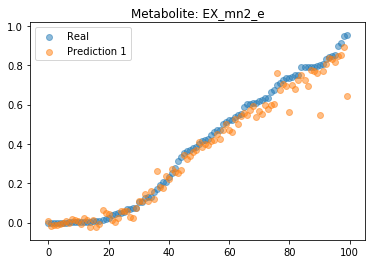

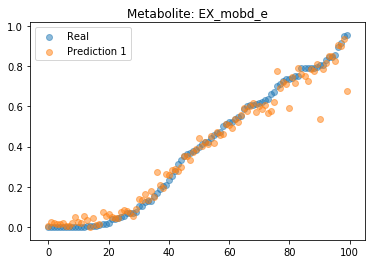

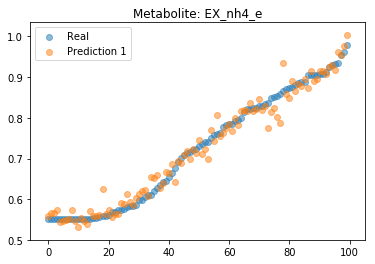

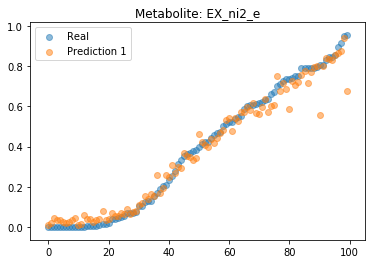

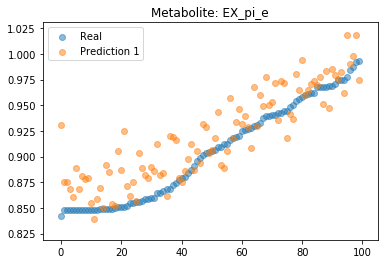

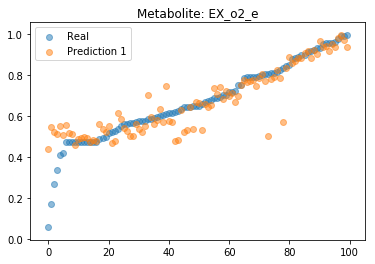

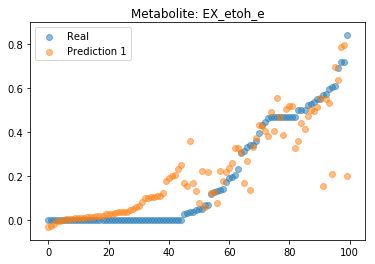

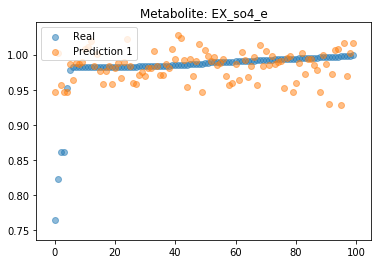

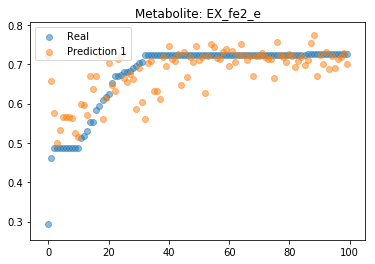

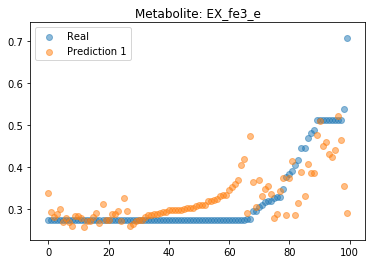

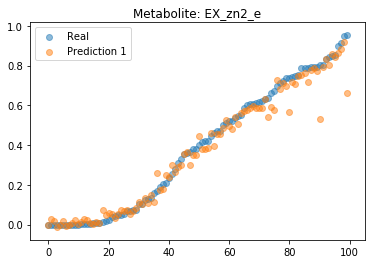

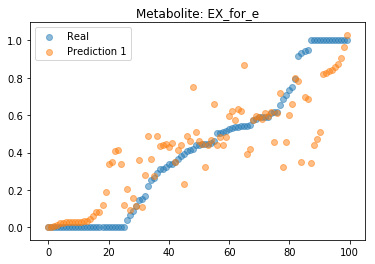

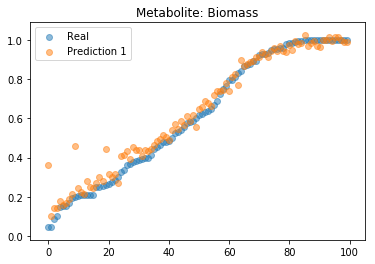

In [255]:
#Visualize the predictions vs the real values of some individuals for each output
for idx in range(outputs_norm.shape[1]):
    plot_prediction_comparison([predictions_met[:200,idx]], outputs_norm[:200,idx], fluxes_metabs[idx])

In [43]:
#Tries the model on other strains
dataFolder2 = 'modelsMixed/'
modelbases2 = ['iEC042','iAPECO1','iJO1366','iWFL','iYS1720']
nFBAs2 = 5000

for i in range(len(modelbases2)):
    modelbase2 = modelbases2[i]
    print('\nResults for :', modelbase2)
    
    filebase2 = 'FBAs_{}_random_test'.format(modelbase2)
    append=False
    FBAmodel2=cobra.io.load_json_model(dataFolder2+modelbase2+'.json')

    medium_metabs2 = get_influxesIds(FBAmodel2)
    fluxes_metabs2_raw = get_fluxesIds(FBAmodel2)

    premade_FBA = [filebase2+'_inputs.pickle', filebase2+'_outputs.pickle']
    if append or not premade_FBA[1] in os.listdir() or not premade_FBA[1] in os.listdir():
        runFBAs(FBAmodel2, filebase2, nFBAs2, append)
    inputs2, outputs2 = pickle_load(premade_FBA[0], premade_FBA[1])

    #Take only the desired number of individuals
    nFBAsS = min(nFBAs2, inputs2.shape[0])
    inputs2, outputs2 = inputs2[:nFBAs2,:], outputs2[:nFBAs2,:]

    #Gets the reactiosn metabolism input
    inputsM2 = obtainMetabolismInput(FBAmodel2, nFBAs2, inputReactions)

    #Modify the dataset for having the same input-output metabolites as the net expectes (0 if they don't exist)
    inputs_dic, outputs_dic = adaptInputOutputofFBA(inputs2, outputs2, FBAmodel2, net_inputs_dic, net_outputs_dic)
    inputs2, medium_metabs2 = dic2array(inputs_dic)
    outputs2, fluxes_metabs2_raw = dic2array(outputs_dic)

    #Shuffling rows
    inputs2, inputsM2, outputs2 = shuffle_dataset([inputs2, inputsM2, outputs2])

    #Filter the output metabolites, only predicted those with considerable change
    outputs2 = outputs2[:,nonzeros_idx]
    fluxes_metabs2 = fluxes_metabs

    #Normalize inputs and outputs
    inputs2/=1000
    outputs2 = real2norm(outputs2, out_maxs, out_mins)

    print('Input metabolisms shape: ',inputsM2.shape)
    print('Input shape: ',inputs2.shape)
    print('Output shape: ',outputs2.shape)

    print('\n# Evaluate on test data. Results from sequential only metabs')
    results_met2 = model_met.evaluate(inputs2, outputs2)
    mae=results_met2[1]
    predictions_met2 = model_met.predict(inputs2)
    #a_seq = RRMSE(predictions_seq, y_test)
    #print('aRRMSE sequential: ', a_seq)


Results for : iEC042
Input metabolisms shape:  (5000, 1571)
Input shape:  (5000, 25)
Output shape:  (5000, 26)

# Evaluate on test data. Results from sequential only metabs
5000/5000 [==============================] - 0s 82us/sample - loss: 0.0078 - mean_absolute_error: 0.0469

Results for : iAPECO1
Input metabolisms shape:  (5000, 1571)
Input shape:  (5000, 25)
Output shape:  (5000, 26)

# Evaluate on test data. Results from sequential only metabs
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0080 - mean_absolute_error: 0.0472

Results for : iJO1366
Input metabolisms shape:  (5000, 1571)
Input shape:  (5000, 25)
Output shape:  (5000, 26)

# Evaluate on test data. Results from sequential only metabs
5000/5000 [==============================] - 0s 39us/sample - loss: 0.0084 - mean_absolute_error: 0.0474

Results for : iWFL
Input metabolisms shape:  (5000, 1571)
Input shape:  (5000, 25)
Output shape:  (5000, 26)

# Evaluate on test data. Results from sequential o

In [289]:
print('\n# Evaluate on test data. Results from sequential only metabs')
results_met2 = model_met.evaluate(inputs2, outputs2)
mae=results_met2[1]
predictions_met2 = model_met.predict(inputs2)
#a_seq = RRMSE(predictions_seq, y_test)
#print('aRRMSE sequential: ', a_seq)


# Evaluate on test data. Results from sequential only metabs
5000/5000 [==============================] - 0s 65us/sample - loss: 0.1902 - mean_absolute_error: 0.2740


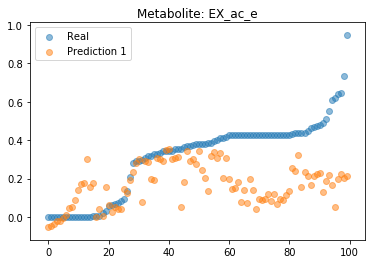

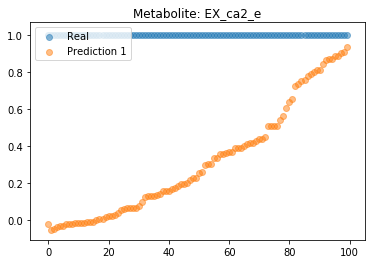

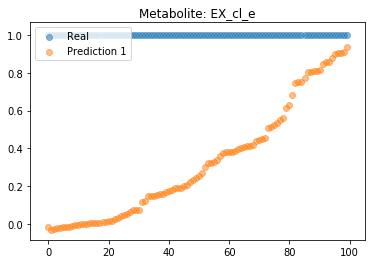

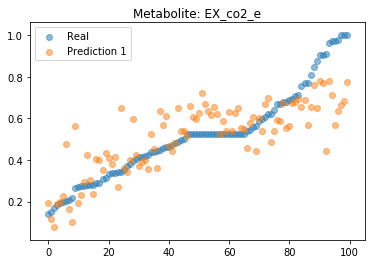

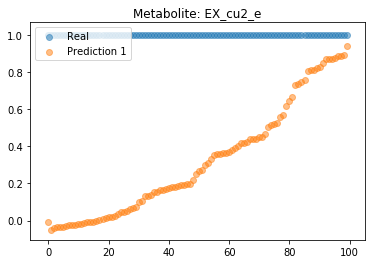

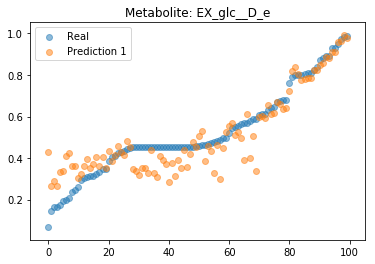

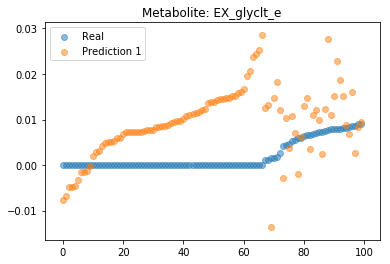

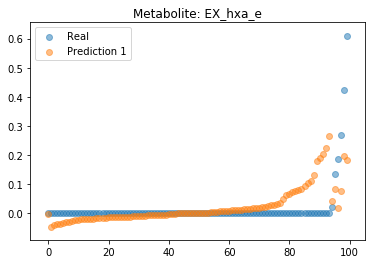

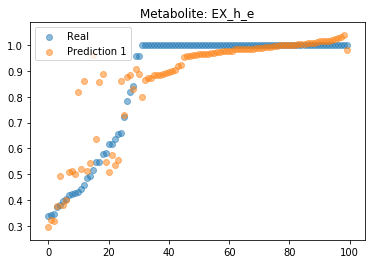

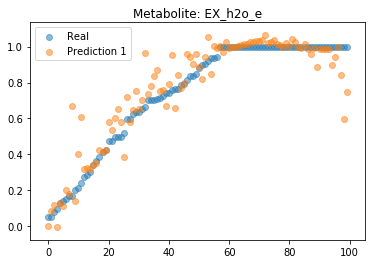

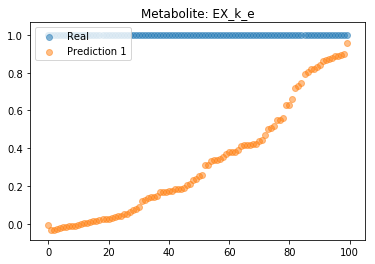

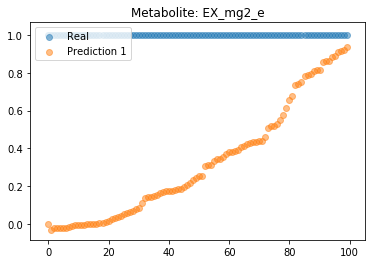

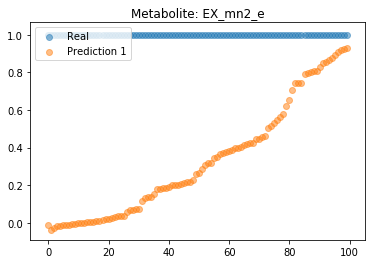

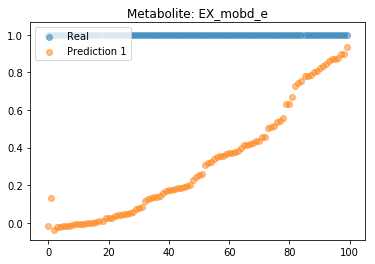

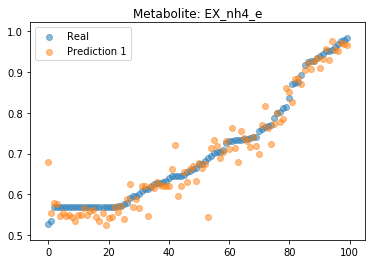

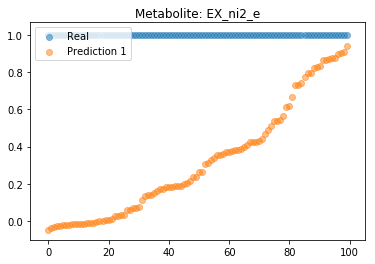

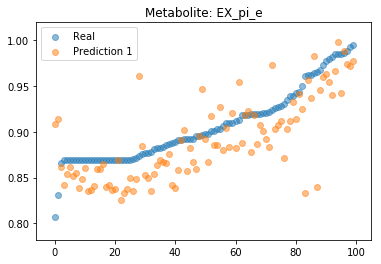

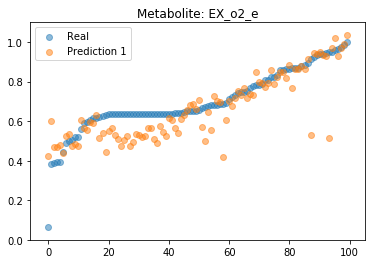

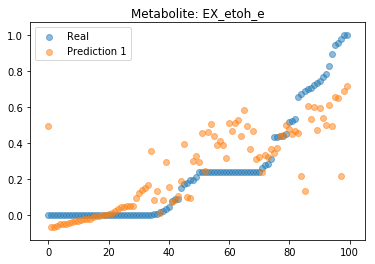

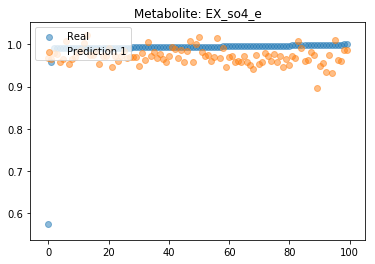

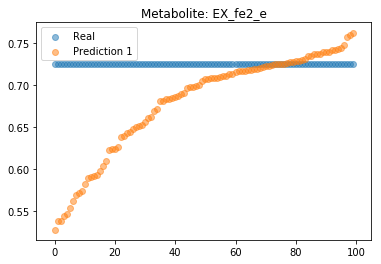

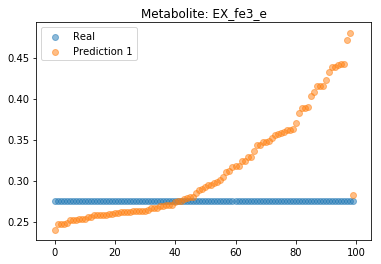

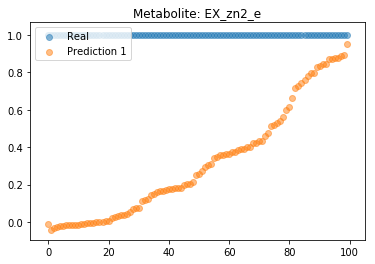

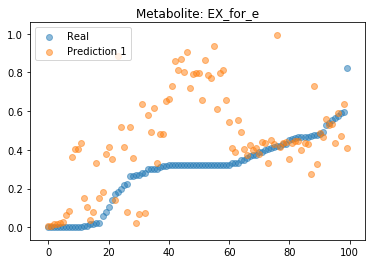

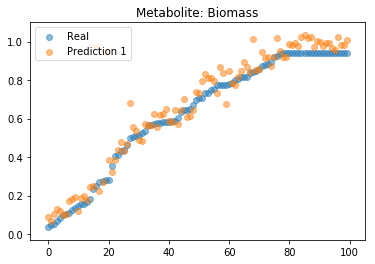

In [290]:
#Visualize the predictions vs the real values of some individuals for each output
for idx in range(outputs2.shape[1]):
    plot_prediction_comparison([predictions_met2[:200,idx]], outputs2[:200,idx], fluxes_metabs[idx])

In [70]:
#Shuffling datasets
inputs, inputsHot, outputs, outputs_norm = shuffle_dataset([inputs, inputsHot, outputs, outputs_norm])

In [44]:
#Red secuencial only metabs + hot vector
net_fn = 'HotVector_metabs_mixed_net.h5'
redo = True
if net_fn in os.listdir() and not redo:
    model_hot = load_model(net_fn)
else:
    history_hot, model_hot = neural_net_sequential(inputsHot,outputs_norm,nepochs=10,vb=1)
    #plot_output(history_met, model_met)
    model_hot.save(net_fn)

Epoch 1/10
10000/10000 [==============================] - 1s 115us/sample - loss: 0.0674 - mean_absolute_error: 0.1837
Epoch 2/10
10000/10000 [==============================] - 1s 71us/sample - loss: 0.0233 - mean_absolute_error: 0.1081
Epoch 3/10
10000/10000 [==============================] - 1s 80us/sample - loss: 0.0138 - mean_absolute_error: 0.0800
Epoch 4/10
10000/10000 [==============================] - 1s 98us/sample - loss: 0.0104 - mean_absolute_error: 0.0651
Epoch 5/10
10000/10000 [==============================] - 1s 87us/sample - loss: 0.0091 - mean_absolute_error: 0.0578
Epoch 6/10
10000/10000 [==============================] - 1s 72us/sample - loss: 0.0083 - mean_absolute_error: 0.0525
Epoch 7/10
10000/10000 [==============================] - 1s 83us/sample - loss: 0.0079 - mean_absolute_error: 0.0497
Epoch 8/10
10000/10000 [==============================] - 1s 83us/sample - loss: 0.0076 - mean_absolute_error: 0.0468
Epoch 9/10
10000/10000 [==============================]

In [37]:
print('\n# Evaluate on test data. Results from sequential only metabs')
results_hot = model_hot.evaluate(inputsHot, outputs_norm)
predictions_hot = model_hot.predict(inputsHot)
#a_seq = RRMSE(predictions_seq, y_test)
#print('aRRMSE sequential: ', a_seq)


# Evaluate on test data. Results from sequential only metabs
10000/10000 [==============================] - 1s 94us/sample - loss: 0.0076 - mean_absolute_error: 0.0440


In [45]:
#Tries the one hot vector system on other strains
dataFolder2 = 'modelsMixed/'
modelbases2 = ['iEC042','iAPECO1','iJO1366','iWFL','iYS1720']
nFBAs2 = 5000

for i in range(len(modelbases2)):
    modelbase2 = modelbases2[i]
    print('\nResults for :', modelbase2)
    
    filebase2 = 'FBAs_{}_random_test'.format(modelbase2)
    append=False
    FBAmodel2=cobra.io.load_json_model(dataFolder2+modelbase2+'.json')

    medium_metabs2 = get_influxesIds(FBAmodel2)
    fluxes_metabs2_raw = get_fluxesIds(FBAmodel2)

    premade_FBA = [filebase2+'_inputs.pickle', filebase2+'_outputs.pickle']
    if append or not premade_FBA[1] in os.listdir() or not premade_FBA[1] in os.listdir():
        runFBAs(FBAmodel2, filebase2, nFBAs2, append)
    inputs2, outputs2 = pickle_load(premade_FBA[0], premade_FBA[1])

    #Take only the desired number of individuals
    nFBAsS = min(nFBAs2, inputs2.shape[0])
    inputs2, outputs2 = inputs2[:nFBAs2,:], outputs2[:nFBAs2,:]

    #Modify the dataset for having the same input-output metabolites as the net expectes (0 if they don't exist)
    inputs_dic, outputs_dic = adaptInputOutputofFBA(inputs2, outputs2, FBAmodel2, net_inputs_dic, net_outputs_dic)
    inputs2, medium_metabs2 = dic2array(inputs_dic)
    outputs2, fluxes_metabs2_raw = dic2array(outputs_dic)

    #Filter the output metabolites, only predicted those with considerable change
    outputs2 = outputs2[:,nonzeros_idx]
    fluxes_metabs2 = fluxes_metabs

    #Normalize inputs and outputs
    inputs2/=1000
    outputs2 = real2norm(outputs2, out_maxs, out_mins)
    
    #Adding the one hot vector input
    inputsHot2 = oneHotVector(inputs2, modelbases2, i)
    inputsHot2 = np.concatenate((inputsHot2, inputs2),axis=1)
    
    #Shuffling rows
    inputs2, inputsHot2, outputs2 = shuffle_dataset([inputs2, inputsHot2, outputs2])

    print('Input hot shape: ',inputsHot2.shape)
    print('Input shape: ',inputs2.shape)
    print('Output shape: ',outputs2.shape)

    print('\n# Evaluate on test data. Results from sequential only metabs')
    results_hot2 = model_hot.evaluate(inputsHot2, outputs2)
    mae=results_hot2[1]
    predictions_hot2 = model_hot.predict(inputsHot2)
    #a_seq = RRMSE(predictions_seq, y_test)
    #print('aRRMSE sequential: ', a_seq)


Results for : iEC042
Input hot shape:  (5000, 30)
Input shape:  (5000, 25)
Output shape:  (5000, 26)

# Evaluate on test data. Results from sequential only metabs
5000/5000 [==============================] - 0s 83us/sample - loss: 0.0076 - mean_absolute_error: 0.0468

Results for : iAPECO1
Input hot shape:  (5000, 30)
Input shape:  (5000, 25)
Output shape:  (5000, 26)

# Evaluate on test data. Results from sequential only metabs
5000/5000 [==============================] - 0s 43us/sample - loss: 0.0081 - mean_absolute_error: 0.0496

Results for : iJO1366
Input hot shape:  (5000, 30)
Input shape:  (5000, 25)
Output shape:  (5000, 26)

# Evaluate on test data. Results from sequential only metabs
5000/5000 [==============================] - 0s 41us/sample - loss: 0.0083 - mean_absolute_error: 0.0489

Results for : iWFL
Input hot shape:  (5000, 30)
Input shape:  (5000, 25)
Output shape:  (5000, 26)

# Evaluate on test data. Results from sequential only metabs
5000/5000 [==================

In [ ]:
#################################
# Tranfer learning
#################################

In [17]:
#TRANSFER LEARNING
#Loads the system and copies it for the transfer system
Ecoli=True
if Ecoli:
    print('Loading Ecoli')
    net_fn_Ecoli = 'Sequential_metabs_mixed_Ecoli_net.h5'
    model_met = load_model(net_fn_Ecoli)
else:
    net_fn_complete = 'Sequential_metabs_mixed_complete_net.h5'
    model_met = load_model(net_fn_complete)

fmodel = copyKerasModel(model_met)

Loading Ecoli
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [18]:
#Tries the multi-strain Ecoli/Complete systems on the Salmonella strain
dataFolderS = 'modelsMixed/'
modelbaseS = 'iYS1720'
filebaseS = 'FBAs_{}_random_test'.format(modelbaseS)
append=False
FBAmodelS=cobra.io.load_json_model(dataFolderS+modelbaseS+'.json')
nFBAsS = 10000

medium_metabsS = get_influxesIds(FBAmodelS)
fluxes_metabsS_raw = get_fluxesIds(FBAmodelS)

premade_FBA = [filebaseS+'_inputs.pickle', filebaseS+'_outputs.pickle']
if append or not premade_FBA[1] in os.listdir() or not premade_FBA[1] in os.listdir():
    runFBAs(FBAmodelS, filebaseS, nFBAsS, append)
inputsS, outputsS = pickle_load(premade_FBA[0], premade_FBA[1])
print('Input shape: ',inputsS.shape)
print('Output shape: ',outputsS.shape)

#Take only the desired number of individuals
nFBAsS = min(nFBAsS, inputsS.shape[0])
inputsS, outputsS = inputsS[:nFBAsS,:], outputsS[:nFBAsS,:]

#Modify the dataset for having the same input-output metabolites as the net expectes (0 if they don't exist)
inputs_dic, outputs_dic = adaptInputOutputofFBA(inputsS, outputsS, FBAmodelS, net_inputs_dic, net_outputs_dic)


Input shape:  (10000, 22)
Output shape:  (10000, 473)


In [19]:
#Create dataset as array
inputsS, medium_metabsS = dic2array(inputs_dic)
outputsS, fluxes_metabsS_raw = dic2array(outputs_dic)

print('Input shape: ',inputsS.shape)
print('Output shape: ',outputsS.shape)

Input shape:  (10000, 24)
Output shape:  (10000, 385)


In [20]:
#Shuffling rows
inputsS, outputsS = shuffle_dataset([inputsS, outputsS])

#Filter the output metabolites, only predicted those with considerable change
outputsS = outputsS[:,nonzeros_idx]
fluxes_metabsS = fluxes_metabs

#Normalize inputs and outputs
inputsS/=1000
norm_outputsS = real2norm(outputsS, out_maxs, out_mins)

print('Input shape: ',inputsS.shape)
print('Output shape: ',outputsS.shape)

Input shape:  (10000, 24)
Output shape:  (10000, 25)


In [21]:
print('\n# Evaluate on test data (raw output)')
resultsS = fmodel.evaluate(inputsS, norm_outputsS)
print('test MSE, test acc, test MAE:', resultsS)

bioIdx = biomassIndex(fluxes_metabsS)
print('\n# Generate predictions')
predictionsS = fmodel.predict(inputsS)
print('Biomass MAE: ', mean_absolute_error(norm_outputsS[:,-1],predictionsS[:,-1]))


# Evaluate on test data (raw output)
10000/10000 [==============================] - 0s 42us/sample - loss: 0.1841 - mean_absolute_error: 0.2707
test MSE, test acc, test MAE: [0.1841043351650238, 0.27073687]

# Generate predictions
Biomass MAE:  0.05021987053441503


In [22]:
totMAES = resultsS[1]
bioMAES = mean_absolute_error(norm_outputsS[:,bioIdx],predictionsS[:,bioIdx])

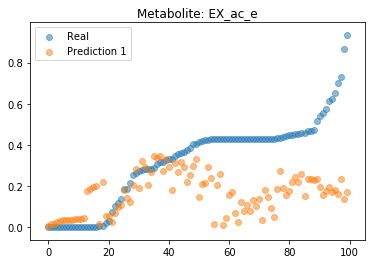

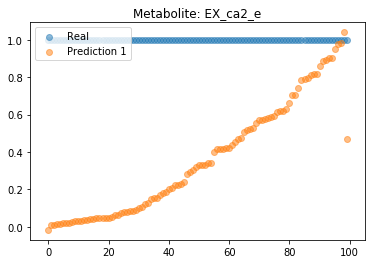

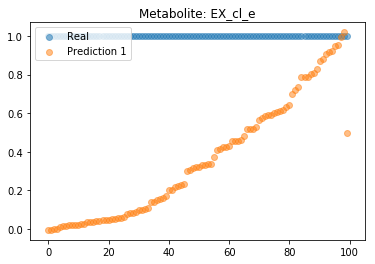

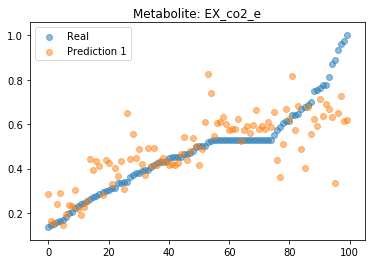

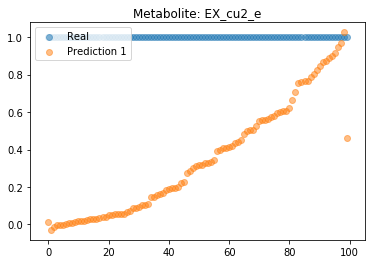

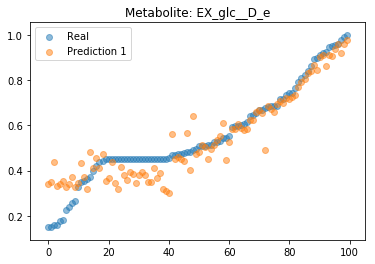

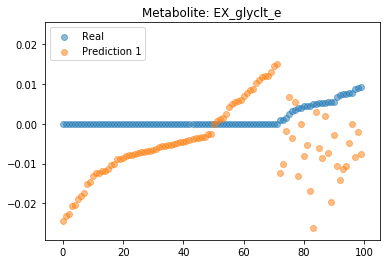

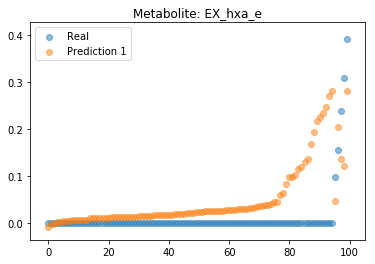

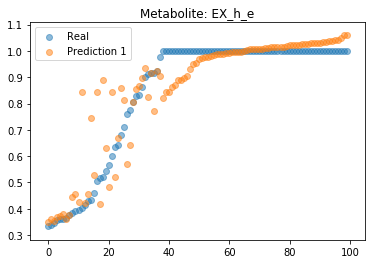

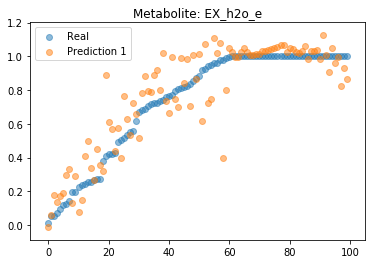

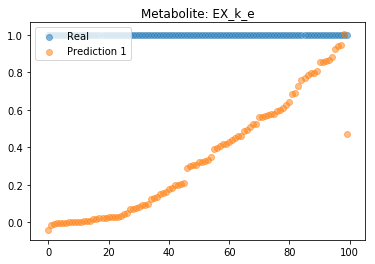

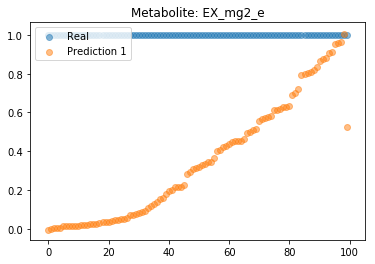

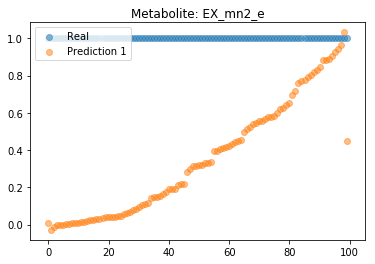

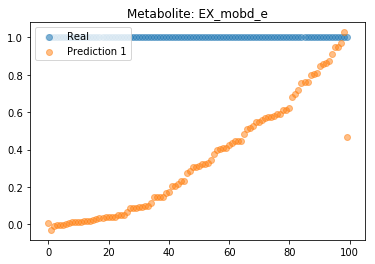

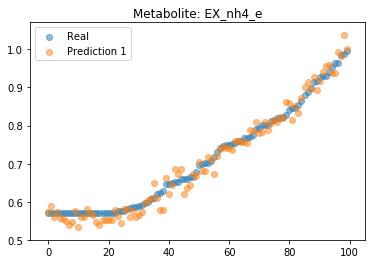

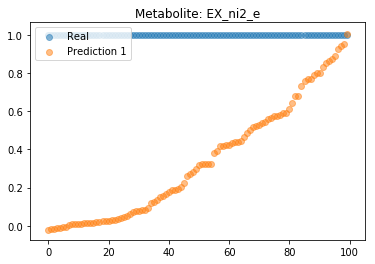

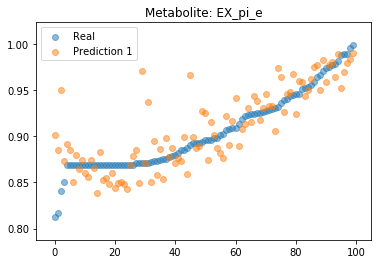

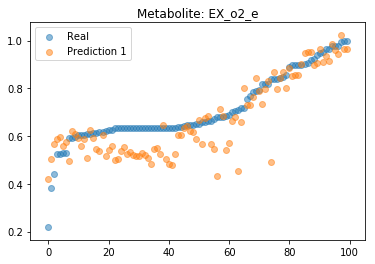

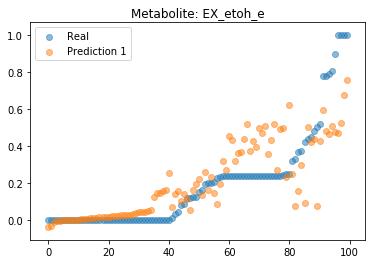

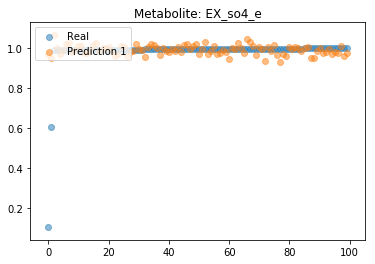

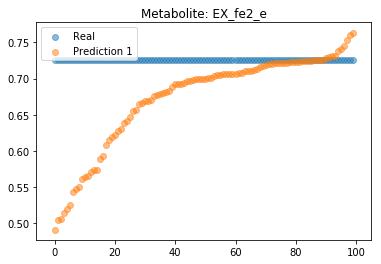

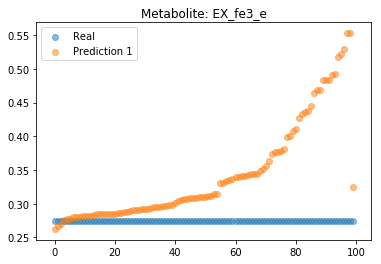

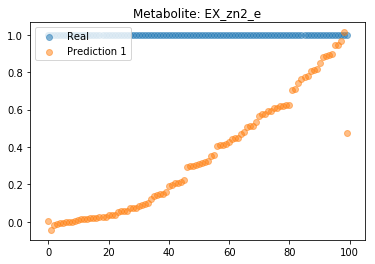

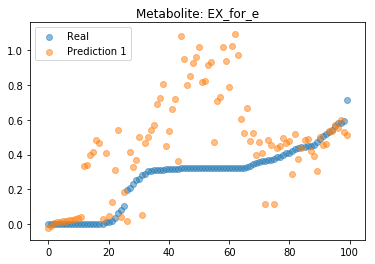

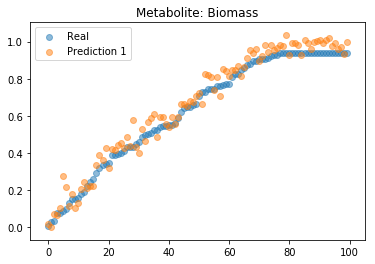

In [39]:
#Visualize the predictions vs the real values of some individuals for each output
for idx in range(outputsS.shape[1]):
    plot_prediction_comparison([predictionsS[:200,idx]], norm_outputsS[:200,idx], fluxes_metabs[idx])

In [23]:
#Transfer learning for different number of new retraining isntances
train_props = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
val_prop = 0.1

transf_tMAEs, transf_bMAEs = [], []
for train_prop in train_props:
    print('Training on {} instances'.format(int(train_prop*inputsS.shape[0])))
    ncv=4
    tEr, bEr = [], []
    for i in range(ncv):
        tr_inputsS, tr_norm_outputsS = shuffle_dataset([inputsS, norm_outputsS])
        x_trainS, x_valS, x_testS = divide_set(tr_inputsS, train_prop, val_prop)
        y_trainS, y_valS, y_testS = divide_set(tr_norm_outputsS, train_prop, val_prop)

        model_transferS = copyKerasModel(model_met)
        history = model_transferS.fit(x_trainS, y_trainS, epochs=5, verbose=0 , validation_data=(x_valS, y_valS))

        predictionsS = model_transferS.predict(x_testS)
        bEr.append(mean_absolute_error(y_testS[:,bioIdx],predictionsS[:,bioIdx]))
        tEr.append(mean_absolute_error(y_testS[:,:],predictionsS[:,:]))
    print('Average MAE: ', np.mean(tEr))
    print('Average bioMAE: ', np.mean(bEr))
    transf_tMAEs.append(np.mean(tEr))
    transf_bMAEs.append(np.mean(bEr))

Training on 100 instances
Average MAE:  0.1355284691624406
Average bioMAE:  0.11203025653973217
Training on 200 instances
Average MAE:  0.09484732871360219
Average bioMAE:  0.13442716314620162
Training on 500 instances
Average MAE:  0.06491921966075909
Average bioMAE:  0.11020769233091504
Training on 1000 instances
Average MAE:  0.05176535804575685
Average bioMAE:  0.07886840181833601
Training on 2000 instances
Average MAE:  0.04022183976610862
Average bioMAE:  0.05264073355571829
Training on 5000 instances
Average MAE:  0.03249049274586249
Average bioMAE:  0.03937139397650562


In [24]:
#Adapting the x axis
train_props = np.array(train_props)* inputsS.shape[0]
train0_props = [0]+list(train_props)
print(train0_props)

[0, 100.0, 200.0, 500.0, 1000.0, 2000.0, 5000.0]


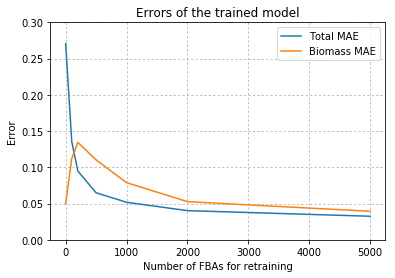

In [26]:
#Plots the results of the anlysis
t0MAEs, b0MAEs = [totMAES]+transf_tMAEs, [bioMAES]+transf_bMAEs
plt.plot(train0_props, t0MAEs, label='Total MAE')
plt.plot(train0_props, b0MAEs, label='Biomass MAE')

plt.legend(loc='upper right')
plt.xlabel('Number of FBAs for retraining')
plt.ylabel('Error')
plt.ylim(0,0.3)
#plt.axhline(y=0.05, color='r', linestyle='dotted')
plt.title('Errors of the trained model')
plt.grid(linestyle='dotted')
plt.savefig('images/multiTransferSalmonella_Ecoli2.jpg')
plt.show()

In [100]:
#Testing the model with another specie
dataFolderS = 'modelsOthers/'
modelbaseS = 'iYS1720'
filebaseS = 'FBAs_{}_random'.format(modelbaseS)
append=False
FBAmodelS=cobra.io.load_json_model(dataFolderS+modelbaseS+'.json')
nFBAsS = 10000

#Prueba de la red modelo en otra cepa
premade_FBA = [filebaseS+'_inputs.pickle', filebaseS+'_outputs.pickle']
if append or not premade_FBA[1] in os.listdir() or not premade_FBA[1] in os.listdir():
    runFBAs(FBAmodelS, filebaseS, nFBAsS, append)
inputsS, outputsS = pickle_load(premade_FBA[0], premade_FBA[1])

#Take only the desired number of individuals
nFBAsS = min(nFBAsS, inputsS.shape[0])
ori_inputsS, ori_outputsS = inputsS[:nFBAsS,:], outputsS[:nFBAsS,:]

print('InputsS shape: ',ori_inputsS.shape)
print('OutputsS shape: ',ori_outputsS.shape)

InputsS shape:  (10000, 22)
InputsMS shape:  (10000, 3437)
OutputsS shape:  (10000, 473)


In [101]:
#Modify the dataset for having the same input-output metabolites as the net expectes (0 if they don't exist)
inputs_dic, outputs_dic = adaptInputOutputofFBA(ori_inputsS, ori_outputsS, FBAmodelS, net_inputs_dic, net_outputs_dic)
inputsS, medium_metabsS = dic2array(inputs_dic)
outputsS, fluxes_metabsS_raw = dic2array(outputs_dic)

#Shuffles the rows of the data
inputsS, outputsS = shuffle_dataset([inputsS, outputsS])

#Remove output metabolites
outputsS = outputsS[:,nonzeros_idx]
fluxes_metabsS = fluxes_metabs

#Merge inputs
#inputsAllS = np.concatenate((inputsS,inputsMS),axis=1)

print('InputsS shape: ',inputsS.shape)
#print('InputsMS shape: ',inputsMS.shape)
#print('InputsAllS shape: ',inputsAllS.shape)
print('OutputsS shape: ',outputsS.shape)

InputsS shape:  (10000, 29)
InputsMS shape:  (10000, 3437)
InputsAllS shape:  (10000, 3466)
OutputsS shape:  (10000, 25)


In [105]:
print('\n# Evaluate on test data (raw output)')
resultsS = fmodel.evaluate(inputsS, outputsS)
print('test MSE, test acc, test MAE:', resultsS)

print('\n# Generate predictions')
predictionsS = fmodel.predict(inputsS)
print('Biomass MSE: ', mean_square_error(outputsS[:,-1],predictionsS[:,-1]))


# Evaluate on test data (raw output)
10000/10000 [==============================] - 1s 87us/sample - loss: 65.2280 - mean_absolute_error: 2.5970
test MSE, test acc, test MAE: [65.22795131225585, 2.5969849]

# Generate predictions
Biomass MSE:  0.2554898873227728


In [108]:
train_prop = 0.8
val_prop = 0.1

x_trainS, x_valS, x_testS = divide_set(inputsS, train_prop, val_prop)
y_trainS, y_valS, y_testS = divide_set(outputsS, train_prop, val_prop)

Train on 8000 samples, validate on 1000 samples
Epoch 1/10
8000/8000 [==============================] - 2s 225us/sample - loss: 65.1616 - mean_absolute_error: 2.5000 - val_loss: 59.2037 - val_mean_absolute_error: 2.3599
Epoch 2/10
8000/8000 [==============================] - 1s 111us/sample - loss: 64.2383 - mean_absolute_error: 2.4873 - val_loss: 58.3899 - val_mean_absolute_error: 2.2946
Epoch 3/10
8000/8000 [==============================] - 1s 117us/sample - loss: 63.2352 - mean_absolute_error: 2.4475 - val_loss: 60.7308 - val_mean_absolute_error: 2.4445
Epoch 4/10
8000/8000 [==============================] - 1s 121us/sample - loss: 62.3816 - mean_absolute_error: 2.4171 - val_loss: 61.4753 - val_mean_absolute_error: 2.4518
Epoch 5/10
8000/8000 [==============================] - 1s 113us/sample - loss: 60.9259 - mean_absolute_error: 2.3788 - val_loss: 63.1417 - val_mean_absolute_error: 2.4791
Epoch 6/10
8000/8000 [==============================] - 1s 113us/sample - loss: 60.8172 - me

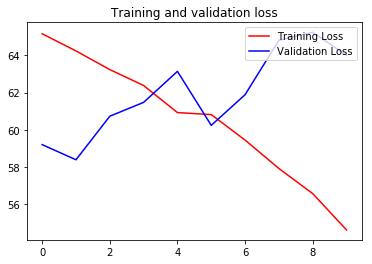

In [110]:
#further retraining 
model_transfer = copyKerasModel(fmodel)
history_transfer = model_transfer.fit(x_trainS, y_trainS, epochs=10, verbose=1 , validation_data=(x_valS, y_valS))
plot_output(history_transfer, model_transfer)

In [111]:
print('\n# Evaluate on test data (raw output)')
results_transfer = model_transfer.evaluate(x_testS, y_testS)
print('test MSE, test acc, test MAE:', results_transfer)

print('\n# Generate predictions')
predictions_transfer = model_transfer.predict(x_testS)
print('Biomass MAE: ', mean_absolute_error(y_testS[:,-1],predictions_transfer[:,-1]))


# Evaluate on test data (raw output)
1000/1000 [==============================] - 0s 62us/sample - loss: 65.5876 - mean_absolute_error: 2.3308
test MSE, test acc, test MAE: [65.58756628417969, 2.330839]

# Generate predictions
Biomass MAE:  0.12591164419334383


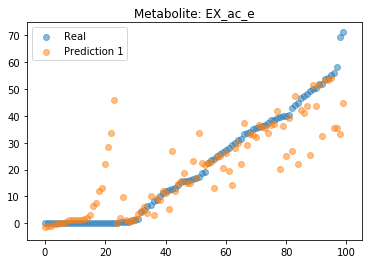

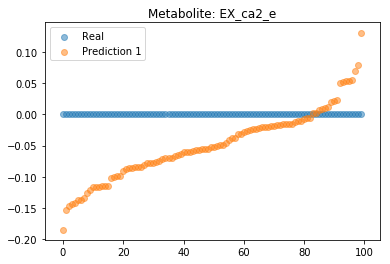

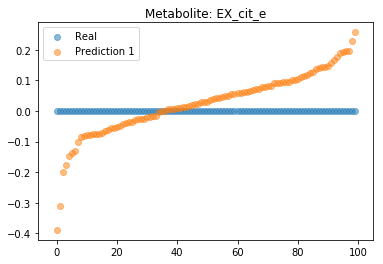

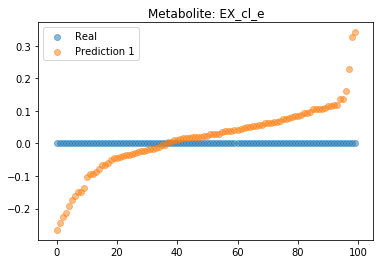

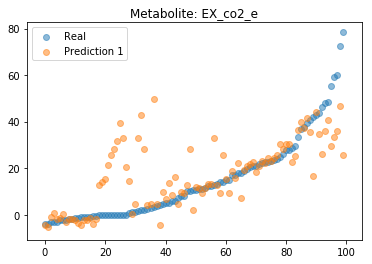

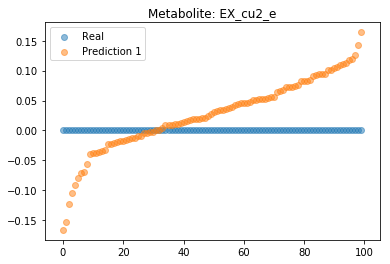

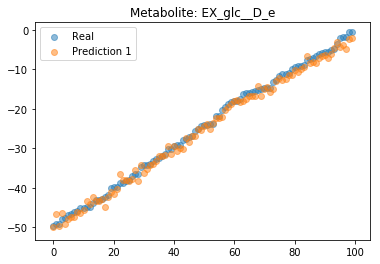

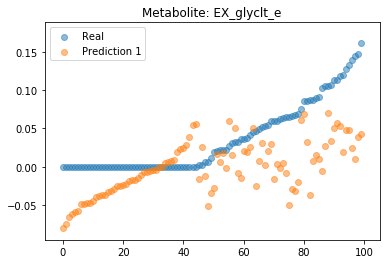

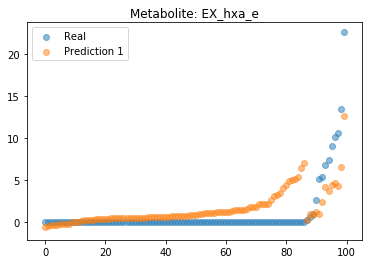

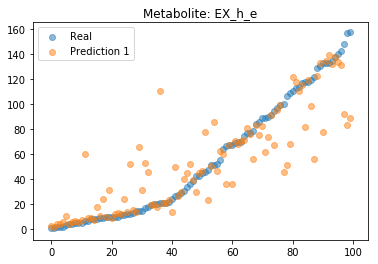

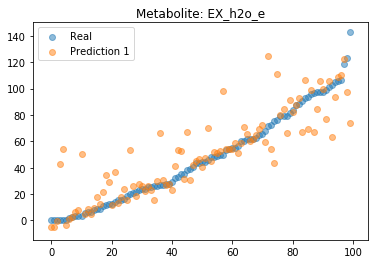

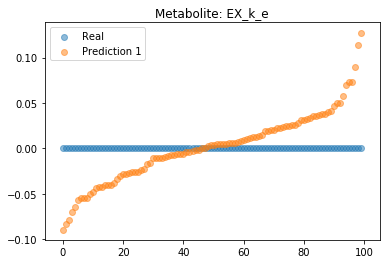

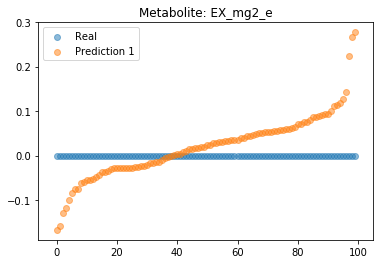

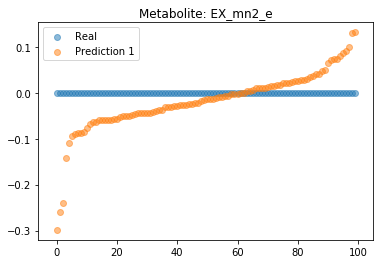

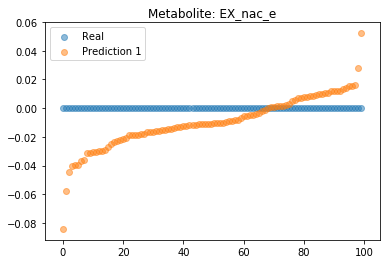

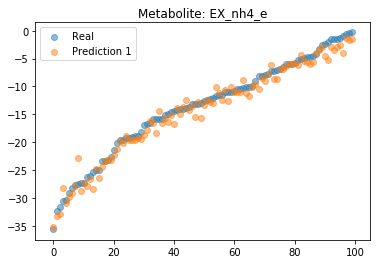

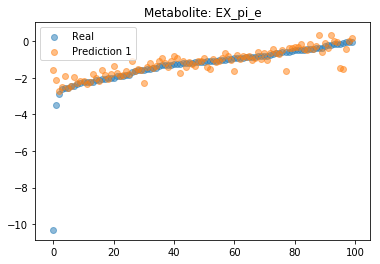

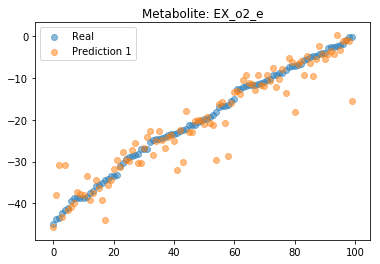

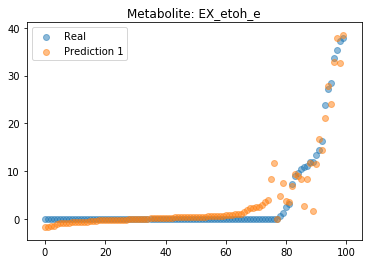

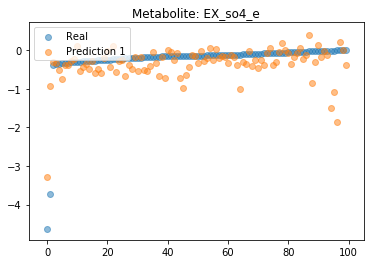

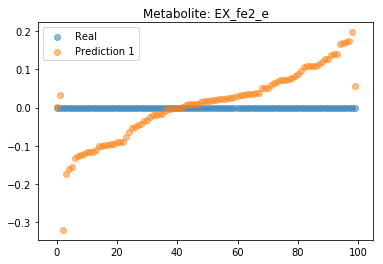

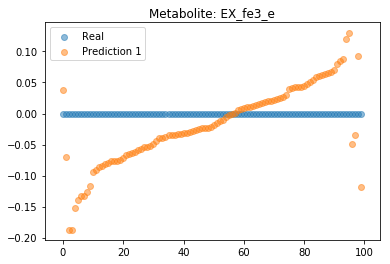

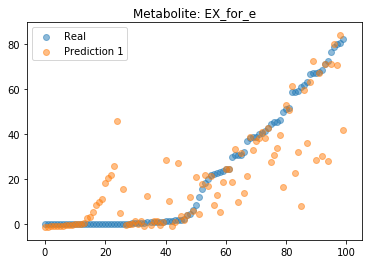

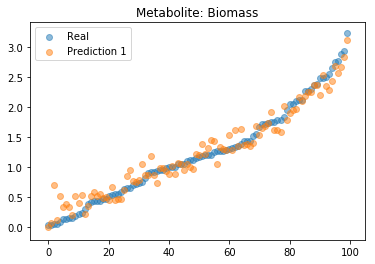

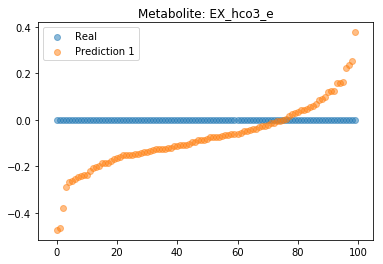

In [113]:
#Visualizing some predictions of the output metabolites 
for idx in range(outputsS.shape[1]):
    plot_prediction_comparison([predictions_transfer[:200,idx]], y_testS[:200,idx], fluxes_metabsS[idx])

In [109]:
#Comparison with build model of salmonella from 0
ori_medium_metabs = get_influxesIds(FBAmodelS)
ori_fluxes_metabs_raw = get_fluxesIds(FBAmodelS)
#Filter the output metabolites, only predicted those with considerable change
nonzeros_idxS = nonzeroidx_output(ori_outputsS, limit = 0.001)

#Remove output metabolites
real_outputsS = ori_outputsS[:,nonzeros_idxS]
real_fluxes_metabsS = np.array(ori_fluxes_metabs_raw)[nonzeros_idxS]

#Shuffles the rows of the data
real_inputsS, real_outputsS = shuffle_dataset([ori_inputsS, real_outputsS])

train_prop = 0.8
val_prop = 0.1

xr_train, xr_val, xr_test = divide_set(real_inputsS, train_prop, val_prop)
yr_train, yr_val, yr_test = divide_set(real_outputsS, train_prop, val_prop)

Train on 16000 samples, validate on 2000 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


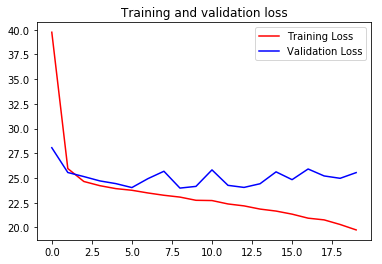

In [110]:
#Red secuencial
net_fn = 'Sequential_{}_net.h5'.format(modelbaseS)
redo = True
if net_fn in os.listdir() and not redo:
    modelS = load_model(net_fn)
else:
    historyS, modelS = neural_net_sequential(xr_train,yr_train, xr_val,yr_val,nepochs=20,vb=4)
    plot_output(historyS, modelS)
    model_seq.save(net_fn)

In [111]:
print('\n# Evaluate on test data (raw output)')
resultsRS = modelS.evaluate(xr_test, yr_test)
print('test MSE, test acc, test MAE:', resultsRS)

print('\n# Generate predictions')
predictionsr = modelS.predict(xr_test)
print('Biomass MAE: ', mean_absolute_error(yr_test[:,-1],predictionsr[:,-1]))


# Evaluate on test data (raw output)
2000/2000 [==============================] - 0s 47us/sample - loss: 26.9159 - mean_absolute_error: 1.1029
test MSE, test acc, test MAE: [26.915918060302733, 1.1028564]

# Generate predictions
Biomass MAE:  0.18839438983644413


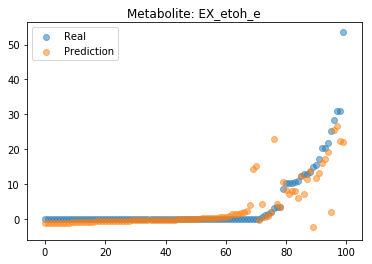

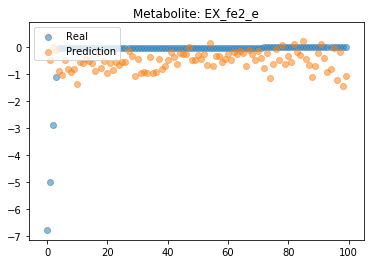

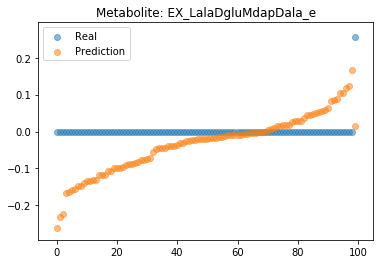

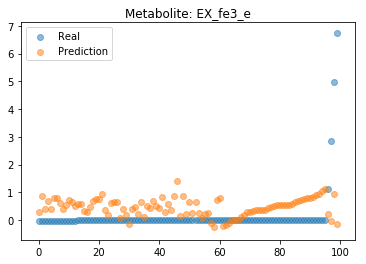

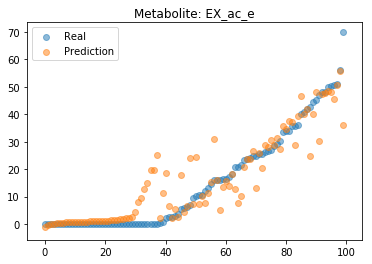

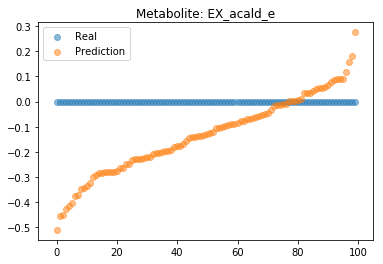

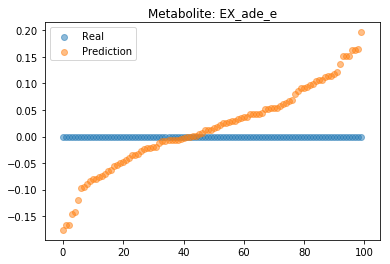

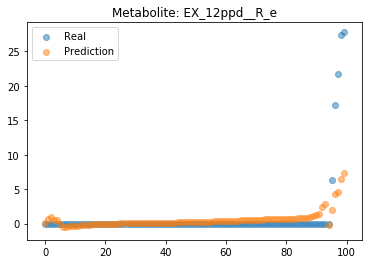

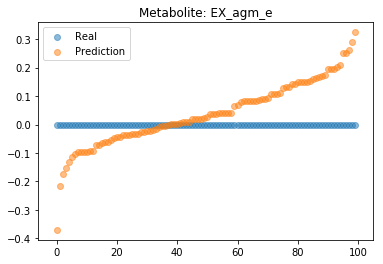

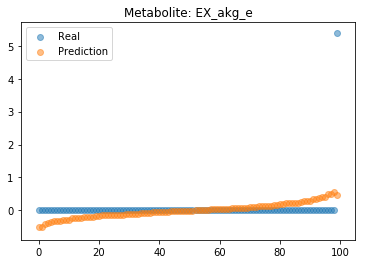

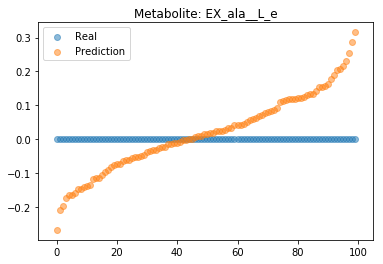

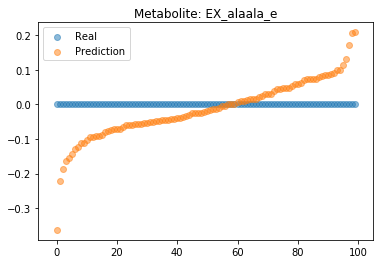

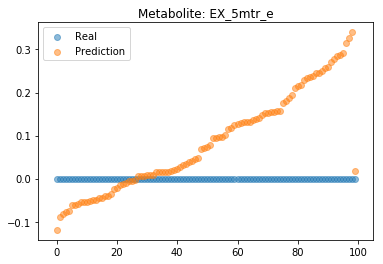

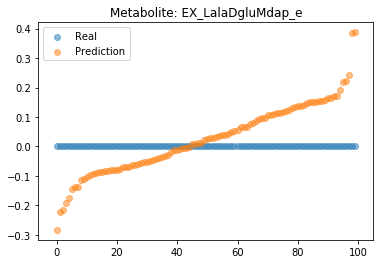

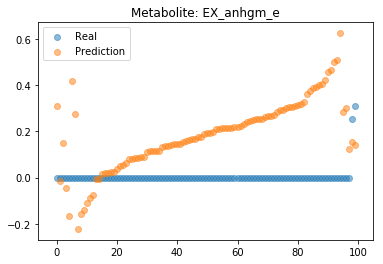

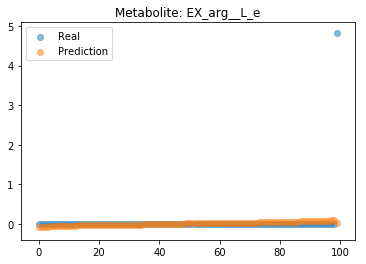

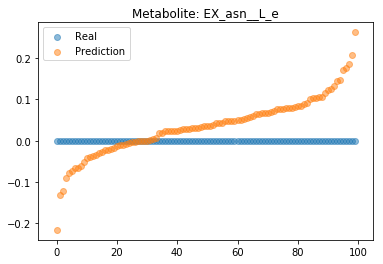

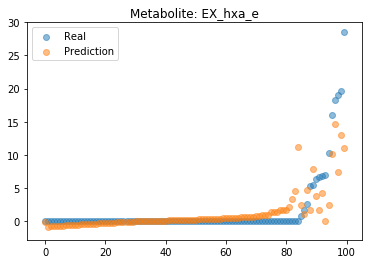

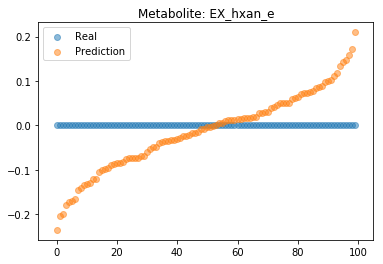

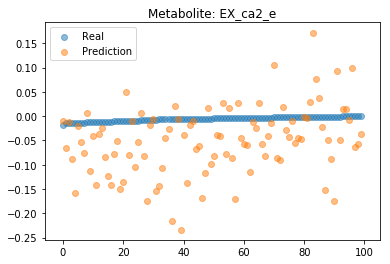

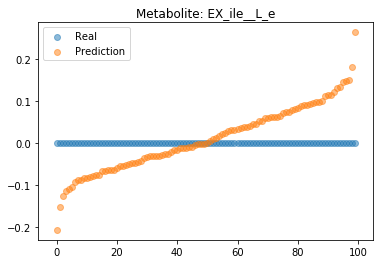

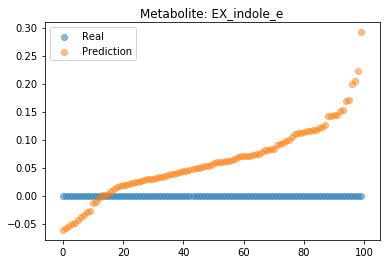

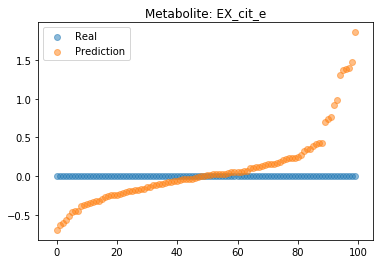

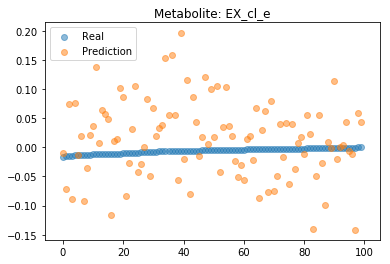

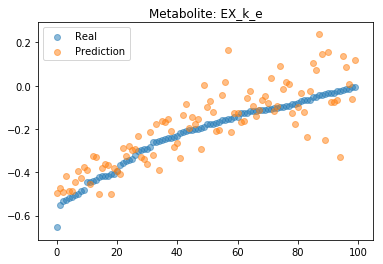

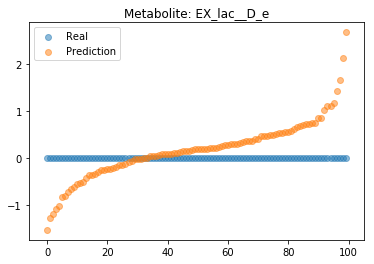

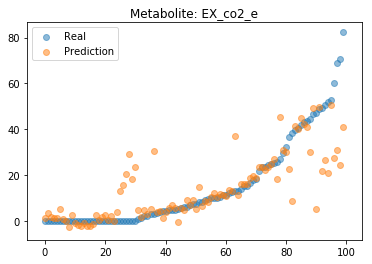

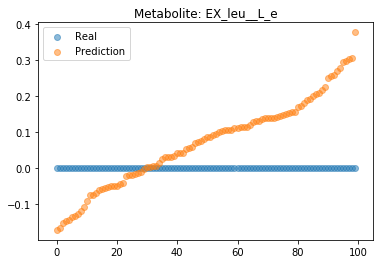

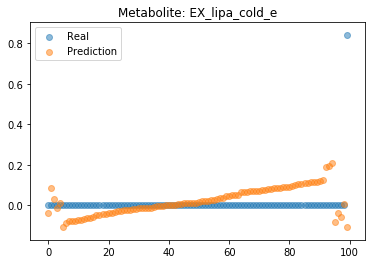

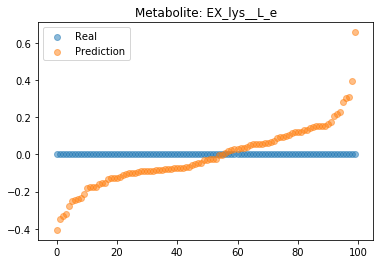

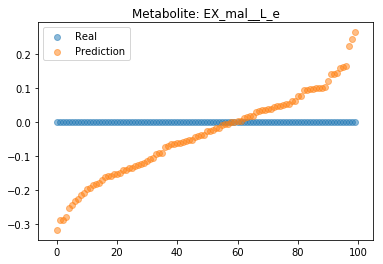

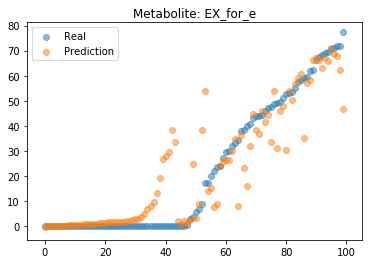

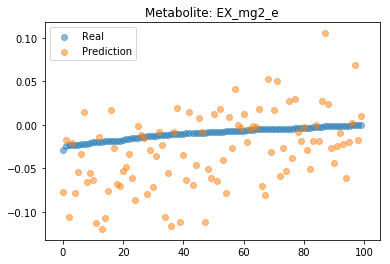

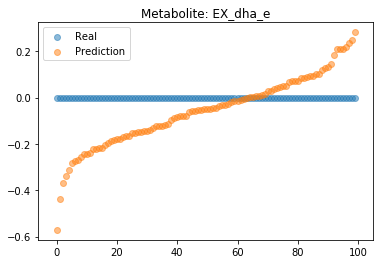

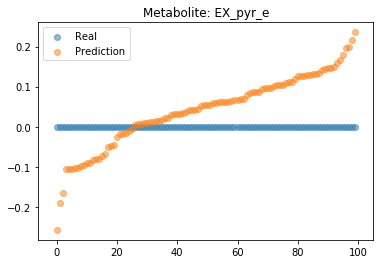

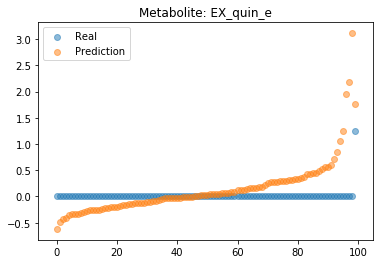

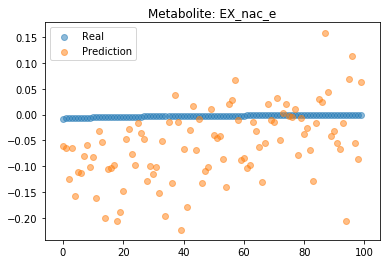

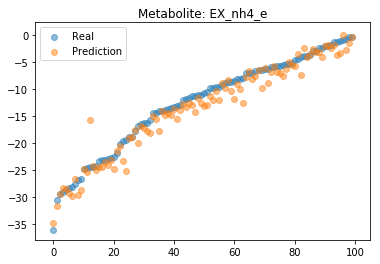

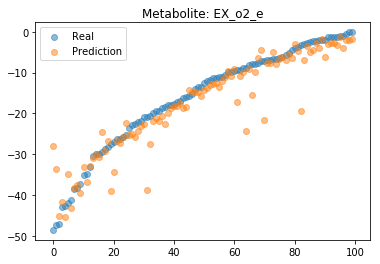

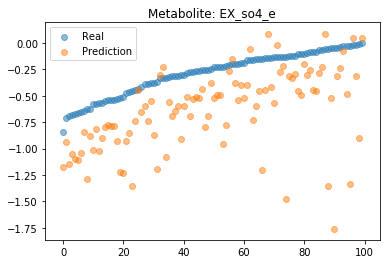

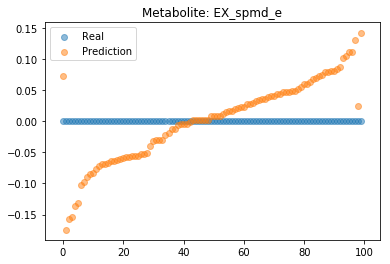

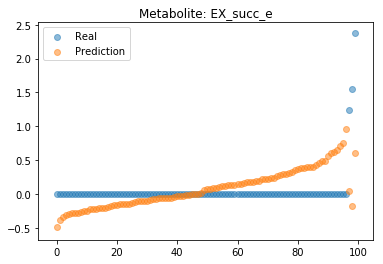

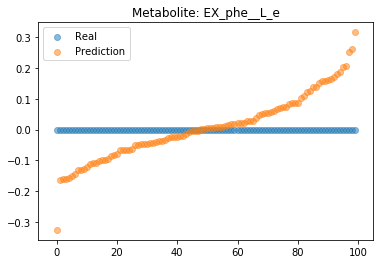

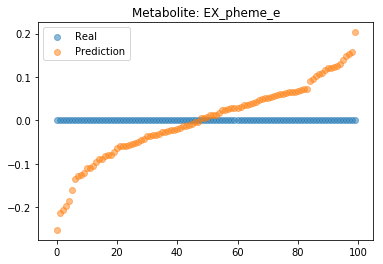

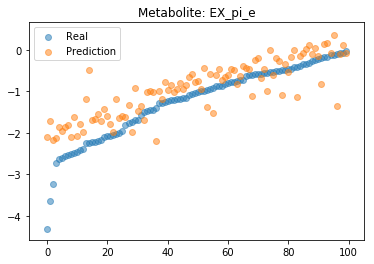

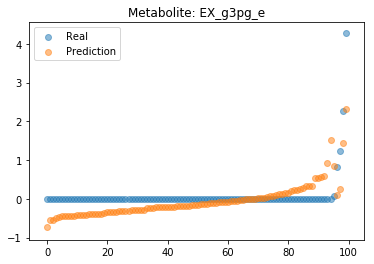

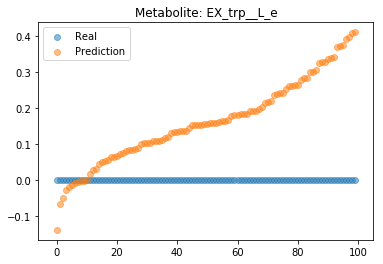

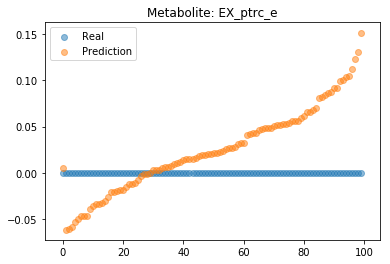

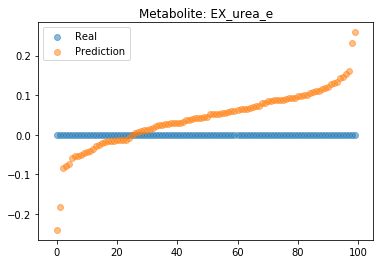

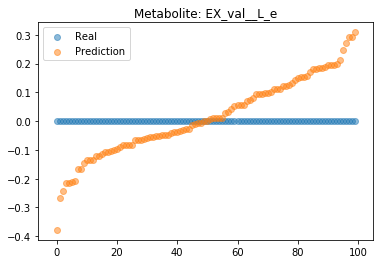

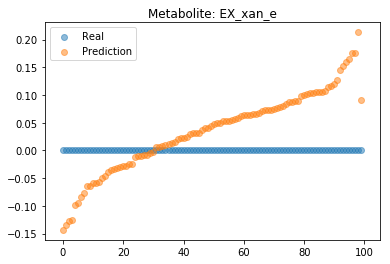

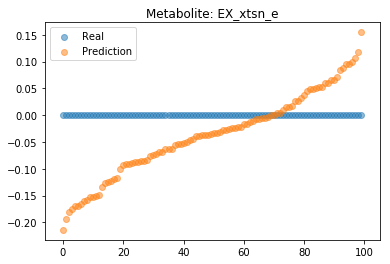

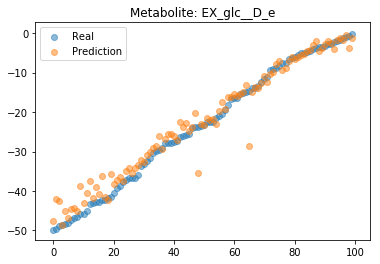

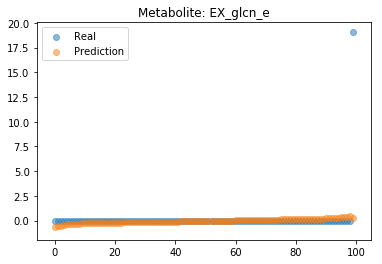

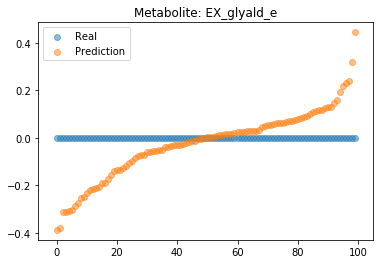

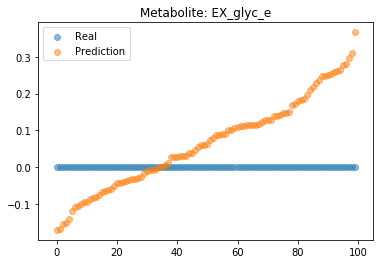

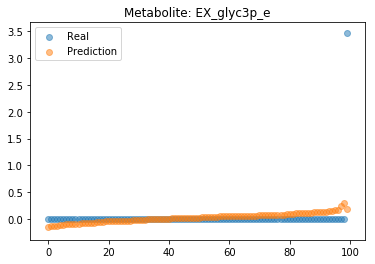

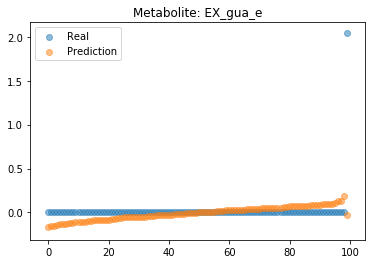

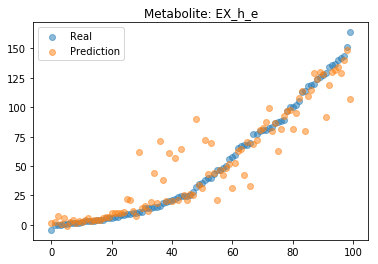

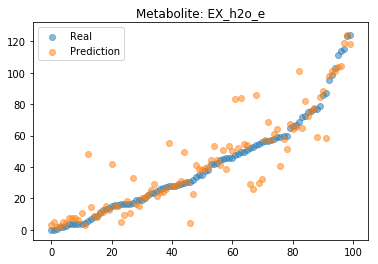

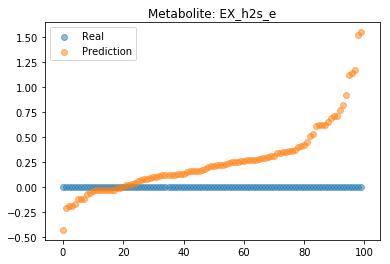

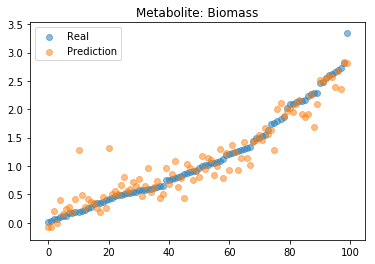

In [112]:
#Visualizing some predictions of the output metabolites 
for idx in range(real_outputsS.shape[1]):
    plot_prediction_comparison(predictionsr[:100,idx], yr_test[:100,idx], real_fluxes_metabsS[idx])

In [97]:
print('Metabolites in Ecoli models, not in salmonella: ',set(fluxes_metabsS).difference(set(real_fluxes_metabsS)))
print('\nMetabolites in salmonella models, not in ecoli: ',set(real_fluxes_metabsS).difference(set(fluxes_metabsS)))                

Metabolites in Ecoli models, not in salmonella:  {'EX_lipa_cold_e', 'EX_ca2_e', 'EX_k_e', 'EX_quin_e', 'EX_glyc3p_e', 'EX_cit_e', 'EX_fe3_e', 'EX_lac__L_e', 'EX_hxan_e', 'EX_dha_e', 'EX_3hpp_e', 'EX_asn__L_e', 'EX_5mtr_e', 'EX_spmd_e', 'EX_mal__L_e', 'EX_12ppd__S_e', 'EX_glyc__R_e', 'EX_cl_e', 'EX_glyc_e', 'EX_pheme_e', 'EX_mg2_e', 'EX_ala__L_e', 'EX_fe2_e', 'EX_alltn_e'}

Metabolites in salmonella models, not in ecoli:  {'EX_udcpo4min_e', 'EX_phe__L_e', 'EX_fum_e', 'EX_ala__D_e', 'EX_udcpo5_e', 'EX_salchs4_e', 'EX_ser__L_e'}


In [95]:
len(real_fluxes_metabsS)

52